Read proquest news articles from google drive  
make subset of articles that contain the a drug reference (from DOPE)

In [1]:
# ignore warning
import warnings
warnings.filterwarnings('ignore')

In [6]:
import pandas as pd
import json

path = "../Data/"
file_names = ["1Jan2013-31Dec2017.json", "1Jan2018-4Feb2021.json", "5Feb2021-9Mar2023.json"]

articles_df = pd.DataFrame()
for file_name in file_names:
    with open(path + file_name, "r") as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    # concat df
    articles_df = pd.concat([articles_df, df], axis=0)


In [7]:
articles_df.head()
# 159k articles total

Title  \
0  "Unlucky" to some for 365 days.: If '13' scare...   
1  On crime, progress, no turnabout: Nutter happy...   
2                             Wanted: An ideal coach   
3  Local delegations back tax compromise: Raising...   
4  '12 passes without online gaming: As the year ...   

                                           Writer         Date  \
0                              Matza, Michael. \n  01 Jan 2013   
1                                Graham, Troy. \n  01 Jan 2013   
2                                   Ford, Bob. \n  01 Jan 2013   
3  Jonathan Tamari INQUIRER WASHINGTON BUREAU. \n  01 Jan 2013   
4                            Parmley, Suzette. \n  01 Jan 2013   

                                             Details  \
0  /docview/1266634471/fulltext/FDC190CFEFEF44A9P...   
1  /docview/1266634468/fulltext/FDC190CFEFEF44A9P...   
2  /docview/1266634397/fulltext/FDC190CFEFEF44A9P...   
3  /docview/1266634470/fulltext/FDC190CFEFEF44A9P...   
4  /docview/1266634413/fulltext/FDC190CFEFEF44A9P...   

                                                Text  
0  \n\n \n\nFor sufferers of the nation's most po...  
1  \n\n \n\nWhen Mayor Nutter took office in 2008...  
2  \n\n \n\nJeffrey Lurie spent the first five mi...  
3  \n\n \n\nAs Congress scrambled to sidestep som...  
4  \n\n \n\nSeveral Democrats - including New Jer...

In [8]:
# reset index
articles_df.reset_index(drop=True, inplace=True)
# drop 2023
# articles_df = articles_df[articles_df["Date"] < "2023-01-01"]

---

In [11]:
drug_names = pd.read_csv("./data/drug_names.csv")

In [12]:
import re
# concatenate name and commercial name
drugs = drug_names["Name"] + ", " + drug_names["Commercial Names"]
drugs = drugs.apply(lambda x: re.sub(r"[\([{'})\]]", "", x))

In [13]:
# remove No commercial uses
not_drugs = ["No commercial uses", "No commercial names", "Various brand names", "is being researched as therapy for Post Traumatic Stress Disorder PTSD under strict medical supervision.",
             'names include "DM"', "Alcohol", "Sleep Medications", "Over-the-Counter Medicines",
             "an OTC medication for diarrhea", "Imodium", "being researched as therapy for treatment-resistant depression under strict medical supervision.",
             'No commercial uses for ingested "bath salts." No relation to “Epsom salt,” sold as a bath product.', "Tobacco", 
             "Nicotine", "Vaping", "Multiple brand names", "Crack", "Speed", "Spice", "Pot", "Molly", "Crystal", "Sonata", "Coke", "Anabolic"]
drugs = drugs.apply(lambda x: x.split(", "))
# drugs = [drug for drug in drugs if drug not in not_drugs]
real_drugs = []
for row in drugs:
    for thing in row:
        if thing not in not_drugs:
            real_drugs.append(thing)

In [14]:
# to lower
missing_drugs = ["suboxone", "naltrexone", "buprenorphine", "oxy", "narcan", "naloxone"]
real_drugs = [drug.lower() for drug in real_drugs]
# add missing drugs
real_drugs.extend(missing_drugs)
real_drugs = list(set(real_drugs))

In [18]:
# drop 2023

articles_df["Date"] = pd.to_datetime(articles_df["Date"])
articles_df = articles_df[articles_df["Date"].dt.year != 2023]

In [ ]:
# real_drugs

---

### Text processing

- Lowercase Text
- URL Removal
- Contraction Splitting
- Tokenization
- Stemming
- Lemmatization
- Stop Word Removal

In [15]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import contractions

nlp = spacy.load('en_core_web_md', exclude=['tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer'])

In [16]:
def preprocess(text):
    # lower case
    text = text.lower()
    # remove contractions
    text = contractions.fix(text)
    # remove urls
    text = re.sub(r"http\S+", "", text)
    # tokenize
    text = text.split()
    # remove stop words
    text = [token for token in text if token not in STOP_WORDS]

    return text

In [17]:
# preprocess
articles_df["clean_text"] = articles_df["Text"].apply(lambda x: preprocess(x))

In [13]:
# save cleaned articles
# articles_df.to_pickle("./data/articles_df.pkl")

In [11]:
# read
articles_df = pd.read_pickle("./data/articles_df.pkl")

In [20]:
articles_df["clean_text"].head()

0    [sufferers, nation's, popular, superstition,, ...
1    [mayor, nutter, took, office, 2008,, set, auda...
2    [jeffrey, lurie, spent, minutes, news, confere...
3    [congress, scrambled, sidestep, painful, effec...
4    [democrats, -, including, new, jersey, senate,...
Name: clean_text, dtype: object

---

### Extract drug mentions

In [21]:
sample = "this sentence contains the word narcotic and the word methamphetamine and oxy"
[x for x in sample.split() if x in real_drugs]

['methamphetamine', 'oxy']

In [22]:
# first row
articles_df.iloc[0].to_frame().T

Title              Writer  \
0  "Unlucky" to some for 365 days.: If '13' scare...  Matza, Michael. \n   

        Date                                            Details  \
0 2013-01-01  /docview/1266634471/fulltext/FDC190CFEFEF44A9P...   

                                                Text  \
0  \n\n \n\nFor sufferers of the nation's most po...   

                                          clean_text  
0  [sufferers, nation's, popular, superstition,, ...

In [23]:
drug_articles = pd.DataFrame()

In [24]:
for i, row in articles_df.iterrows():
    if any([x in row["clean_text"] for x in real_drugs]):
        matches = [x for x in row["clean_text"] if x in real_drugs]
        row["matches"] = matches
        drug_articles = drug_articles.append(row)

In [25]:
# ~4k articles
drug_articles.head()

Title             Writer  \
1    On crime, progress, no turnabout: Nutter happy...   Graham, Troy. \n   
36   Ringing Out the Old: Tearful Andy Reid says go...   McLane, Jeff. \n   
102  Need better prescription to stop drug abuse: P...               None   
169  Boy, 14, pleads no contest in Bucks: He was ac...  Moran, Robert. \n   
175  Glouco man gets 50 years for woman's murder in...  Lai, Jonathan. \n   

          Date                                            Details  \
1   2013-01-01  /docview/1266634468/fulltext/FDC190CFEFEF44A9P...   
36  2013-01-01  /docview/1266634452/fulltext/FDC190CFEFEF44A9P...   
102 2013-01-03  /docview/1266637065/fulltext/E84A22EC8F384B8BP...   
169 2013-01-04  /docview/1266912057/fulltext/51A554B063CD4A42P...   
175 2013-01-04  /docview/1266912465/fulltext/51A554B063CD4A42P...   

                                                  Text  \
1    \n\n \n\nWhen Mayor Nutter took office in 2008...   
36   \n\n \n\nSometime before 9 a.m. on New Year's ...   
102  \n\n \n\nWhat a top prosecutor calls "the fast...   
169  \n\n \n\nThe 14-year-old boy accused of threat...   
175  \n\n \n\nA 34-year-old Woodbury man was senten...   

                                            clean_text  \
1    [mayor, nutter, took, office, 2008,, set, auda...   
36   [9, a.m., new, year's, eve,, jeffrey, lurie, w...   
102  [prosecutor, calls, "the, fastest-growing, dru...   
169  [14-year-old, boy, accused, threatening, shoot...   
175  [34-year-old, woodbury, man, sentenced, thursd...   

                      matches  
1                   [cocaine]  
36                   [heroin]  
102  [oxycodone, hydrocodone]  
169               [marijuana]  
175                 [cocaine]

In [303]:
# save matching articles to p
# drug_articles.to_pickle("./data/drug_articles.pkl")

In [3]:
drug_articles = pd.read_pickle("./data/drug_articles.pkl")

---

### Exploratory Data Analysis

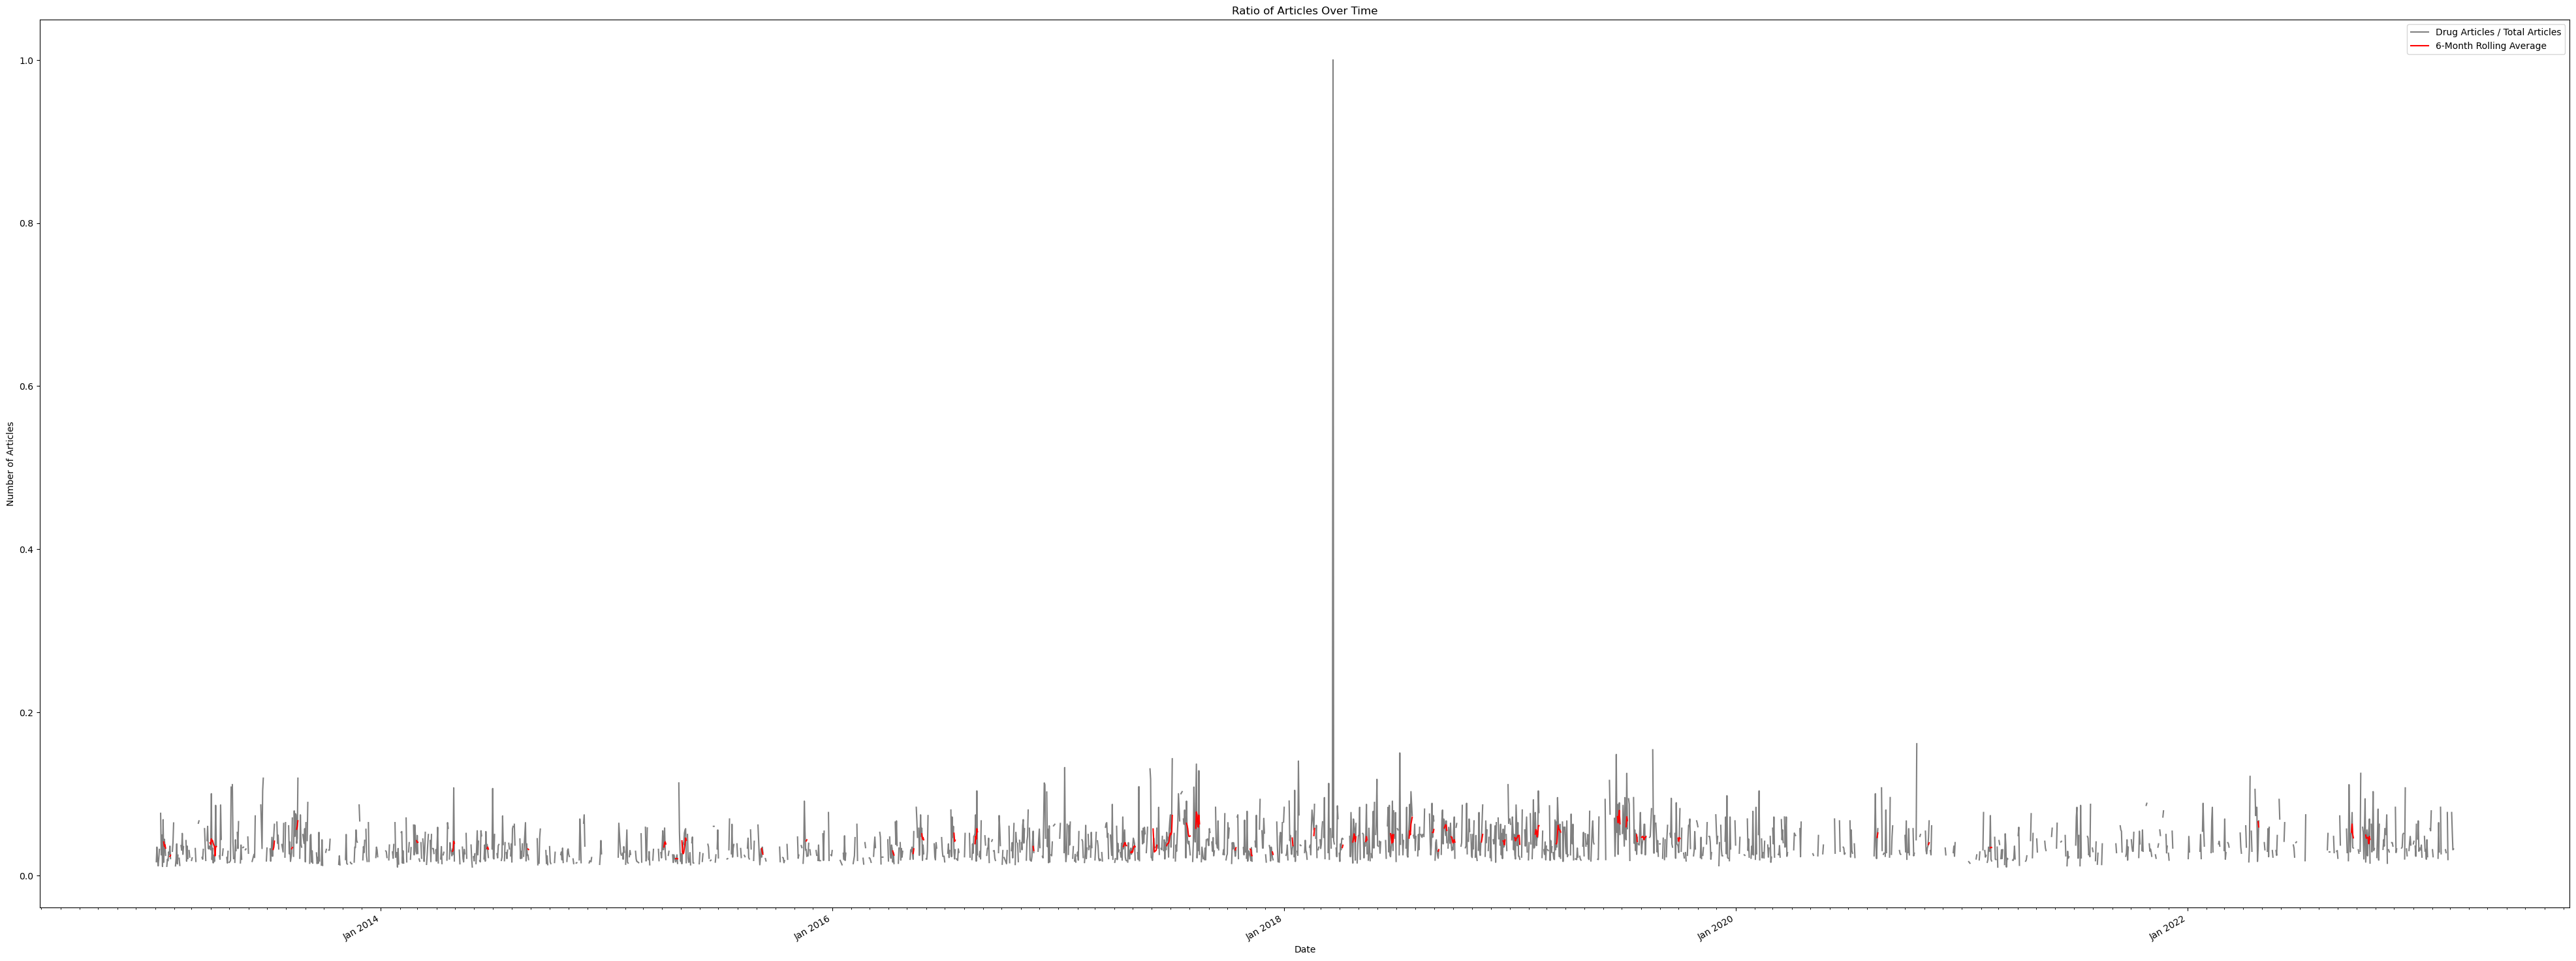

In [18]:
# plot the ratio of drug articles to total articles over time

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

# calculate the ratio of drug articles to total articles over time
drug_articles["Date"] = pd.to_datetime(drug_articles["Date"])
articles_df["Date"] = pd.to_datetime(articles_df["Date"])
date_ratio = drug_articles["Date"].value_counts().sort_index() / articles_df["Date"].value_counts().sort_index()

# plot the ratio of drug articles to total articles over time
fig, ax = plt.subplots(figsize=(50, 20))
ax.plot(date_ratio.index, date_ratio.values, label="Drug Articles / Total Articles", color = "grey")

# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
# rotate and align the tick labels so they look better
fig.autofmt_xdate()
# add y axis label
# ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_minor_locator(ticker.MultipleLocator(50))

# plot rolling average
date_ratio.rolling(6).mean().plot(ax=ax, label="6-Month Rolling Average", color = "red")

ax.set_xlabel("Date")
ax.set_ylabel("Number of Articles")
ax.set_title("Ratio of Articles Over Time")
ax.legend()
plt.show()

there is a proquest issue on march 2018 with very little articles

In [19]:
# number of articles in april of 2018
# the reason for discrepancy in above figure
apr_2018 = drug_articles[drug_articles["Date"].dt.month == 3]
apr_2018 = apr_2018[apr_2018["Date"].dt.day == 21]
apr_2018 = apr_2018[apr_2018["Date"].dt.year == 2018]

print(len(apr_2018))

apr_2018_all = articles_df[articles_df["Date"].dt.month == 3]
apr_2018_all = apr_2018_all[apr_2018_all["Date"].dt.day == 21]
apr_2018_all = apr_2018_all[apr_2018_all["Date"].dt.year == 2018]

print(len(apr_2018_all))

1
1


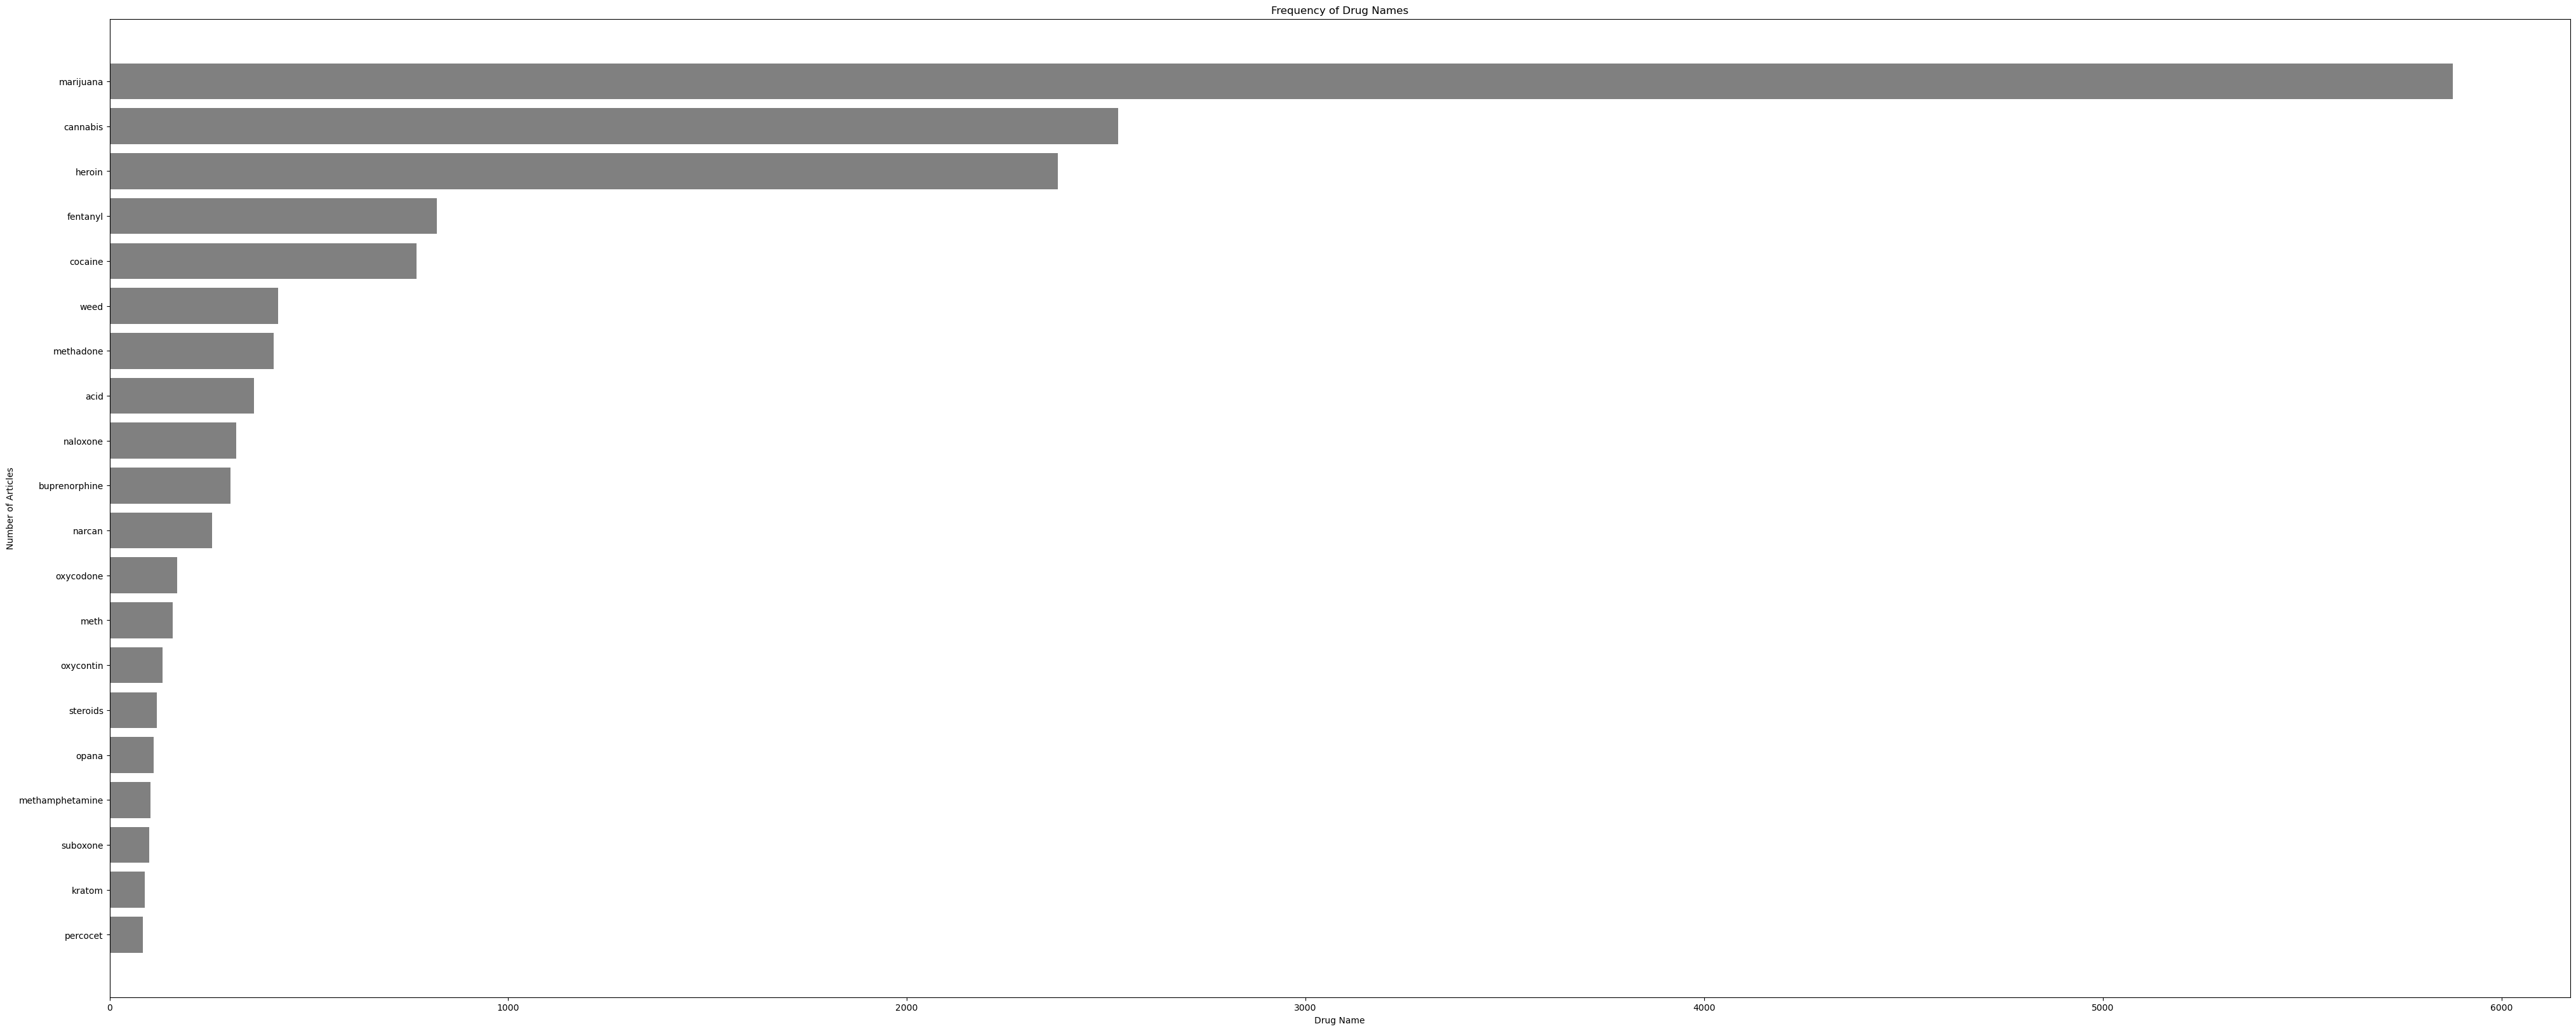

In [20]:
# frequency of drug names
drug_names = drug_articles["matches"].explode().value_counts().head(20)
# plot
fig, ax = plt.subplots(figsize=(50, 20))
ax.barh(drug_names.index, drug_names.values, color = "grey")
# reverse the order of the y axis
ax.invert_yaxis()
ax.set_xlabel("Drug Name")
ax.set_ylabel("Number of Articles")
ax.set_title("Frequency of Drug Names")
plt.show()

In [26]:
drug_articles["drug_mentions"] = drug_articles["matches"].apply(lambda x: len(x))

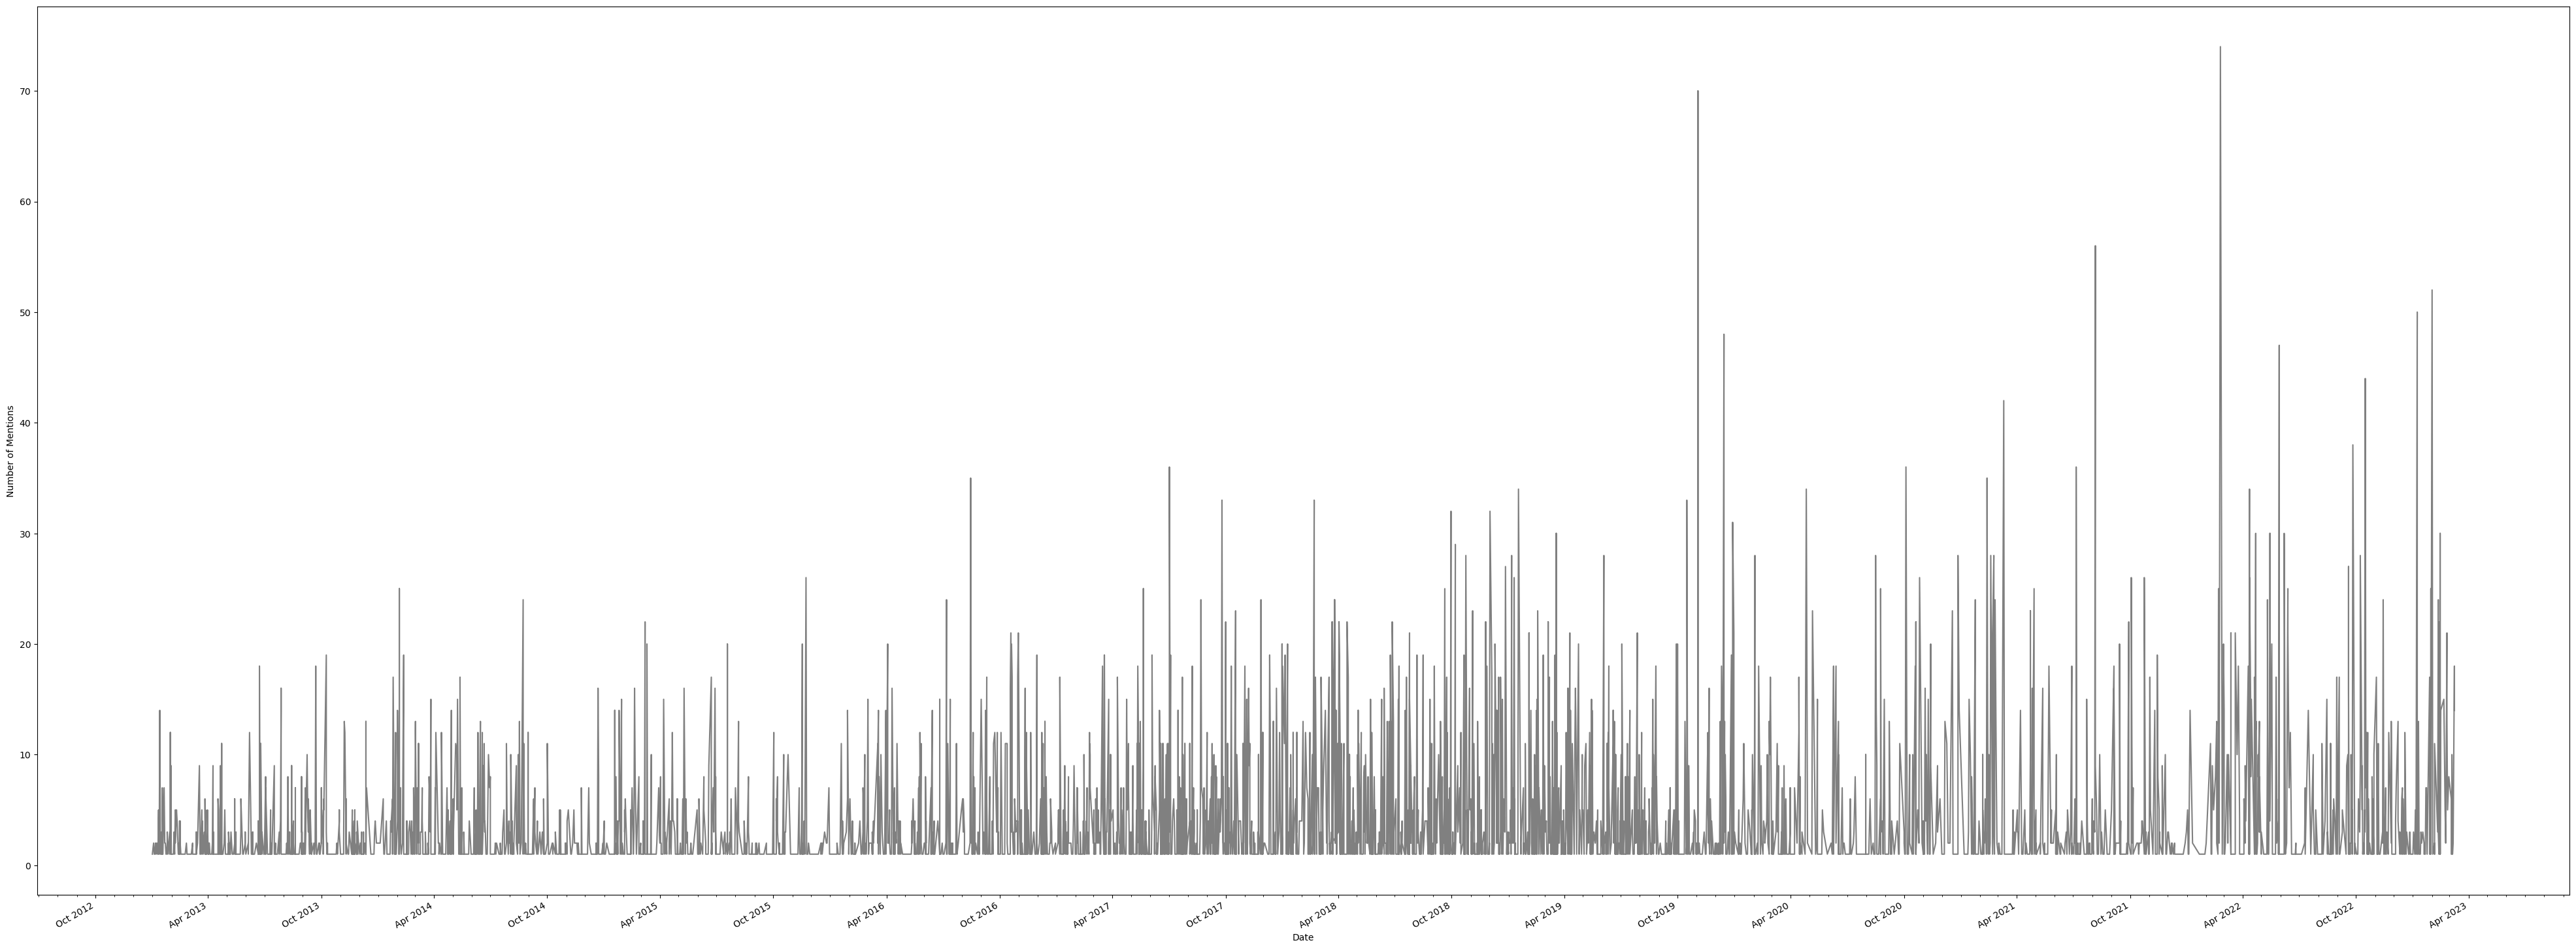

In [22]:
# plot number of drug mentions over time
# drug_mentions = drug_articles["matches", "Date"].explode("matches").groupby("Date").count()

# plot
fig, ax = plt.subplots(figsize=(50, 20))

ax.plot(drug_articles["Date"], drug_articles["drug_mentions"], label="Drug Mentions", color = "grey")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
# rotate and align the tick labels so they look better
fig.autofmt_xdate()
# add y axis label
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_minor_locator(ticker.MultipleLocator(50))
# plot rolling average
# drug_articles["drug_mentions"].rolling(12).mean().plot(ax=ax, label="12-Month Rolling Average", color = "yellow")


ax.set_xlabel("Date")
ax.set_ylabel("Number of Mentions")
plt.show()

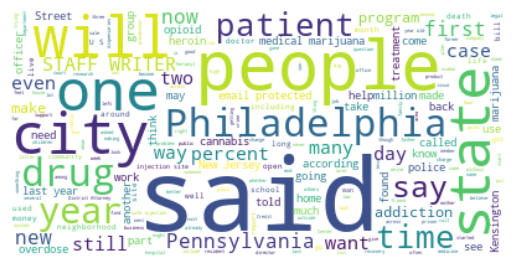

In [122]:
# deeper drive into articles in 2018
# word cloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# join all the text
high_drugs = drug_articles[drug_articles["Date"].dt.year == 2018]
high_drugs_w = high_drugs[high_drugs["Date"] < "2019-12-31"]["Text"].str.cat(sep=" ")

# create word cloud
wc = WordCloud(stopwords=STOPWORDS, background_color="white").generate(high_drugs_w)
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [27]:
# make drug classes: DEA
stimulants = ["cocaine", "methamphetamine", "amphetamine", "speed", "meth", "crystal meth", "adderall", "vyvanse", "ritalin", "dexedrine", "desoxyn", "coke"]
hallucinogens = ["hallucinogens","mdma", "lsd", "ecstasy", "peyote", "mescaline", "mushrooms", "dmt", "ayahuasca", "ketamine", "nitrous", "psilocybin", "pcp", "angel dust", "ketalar", "spravato", "esketamine", "ketaset", "acid", "shrooms"]
depressants = ["barbiturates", "benzodiazepines", "xanax", "valium", "benzos","pentobarbital","nembutal","alprazolam","chlorodiazepoxide","librium","diazepam","valium","lorazepam","ativan","triazolam","halicon","sleep medications","eszopiclone","lunesta","zaleplon","sonata","zolpidem","ambien",
"ghb", "gamma-hydroxybutyric acid", "rohypnol", "flunitrazepam", "sonata", "sodium oxybate", "xyrem"]
narcotics = ["opioids", "heroin", "opiate", "fentanyl", "hydromorphone", "hydrocodone", "oxycodone", "codeine", "morphine", "dilaudid", "percocet", "vicodin", "oxycontin", "actiq", "duragesic", "sublimaze","dihydrocodeinone", "norco", "zohydro","meperidine", "demerol", "morphine duramorph", "MS Contin","percodan", "oxymorphone", "opana", "percs"]
treatment = ["naloxone", "naltrexone", "methadone", "buprenorphine", "suboxone", "subutex", "antabuse", "acamprosate", "naltrexone", "disulfiram", "methadose", "dolophine", "narcan"]
designer_drugs = ["bath salts", "flakka", "k2", "spice", "u-47700", "synthetic cannabinoids", "synthetic cathinones"]
cannabis = ["cannabis", "marijuana", "weed", "thc"]
drugs_of_concern = ["kratom", "salvia", "dxm", "dextromethorphan", "salvia divinorum"]


In [28]:
# create drug class column
drug_articles["class_drug"] = ""
drug_articles["drug_class"] = ""
for i,row in enumerate( drug_articles["matches"]):
    class_drug = []
    for drug in row:
        if drug in stimulants:
            # add key and value to dictionary
            # drug_classes["stimulants"] = drug
            a = ("stimulants", drug)
            class_drug.append(a)
        elif drug in hallucinogens:
            a = ("hallucinogens", drug)
            class_drug.append(a)
        elif drug in depressants:
            a = ("depressants", drug)
            class_drug.append(a)
        elif drug in narcotics:
            a = ("narcotics", drug)
            class_drug.append(a)
        elif drug in treatment:
            a = ("treatment", drug)
            class_drug.append(a)
        elif drug in designer_drugs:
            a = ("designer_drugs", drug)
            class_drug.append(a)
        elif drug in cannabis:
            a = ("cannabis", drug)
            class_drug.append(a)
        elif drug in drugs_of_concern:
            a = ("drugs_of_concern", drug)
            class_drug.append(a)
        else:
            a = ("miscellaneous", drug)
            class_drug.append(a)
    class_drug = list(set(class_drug))
    drug_articles["class_drug"].iloc[i] = class_drug
    drug_articles["drug_class"].iloc[i] = [x[0] for x in class_drug]

In [29]:
drug_articles.head()

Title             Writer  \
1    On crime, progress, no turnabout: Nutter happy...   Graham, Troy. \n   
36   Ringing Out the Old: Tearful Andy Reid says go...   McLane, Jeff. \n   
102  Need better prescription to stop drug abuse: P...               None   
169  Boy, 14, pleads no contest in Bucks: He was ac...  Moran, Robert. \n   
175  Glouco man gets 50 years for woman's murder in...  Lai, Jonathan. \n   

          Date                                            Details  \
1   2013-01-01  /docview/1266634468/fulltext/FDC190CFEFEF44A9P...   
36  2013-01-01  /docview/1266634452/fulltext/FDC190CFEFEF44A9P...   
102 2013-01-03  /docview/1266637065/fulltext/E84A22EC8F384B8BP...   
169 2013-01-04  /docview/1266912057/fulltext/51A554B063CD4A42P...   
175 2013-01-04  /docview/1266912465/fulltext/51A554B063CD4A42P...   

                                                  Text  \
1    \n\n \n\nWhen Mayor Nutter took office in 2008...   
36   \n\n \n\nSometime before 9 a.m. on New Year's ...   
102  \n\n \n\nWhat a top prosecutor calls "the fast...   
169  \n\n \n\nThe 14-year-old boy accused of threat...   
175  \n\n \n\nA 34-year-old Woodbury man was senten...   

                                            clean_text  \
1    [mayor, nutter, took, office, 2008,, set, auda...   
36   [9, a.m., new, year's, eve,, jeffrey, lurie, w...   
102  [prosecutor, calls, "the, fastest-growing, dru...   
169  [14-year-old, boy, accused, threatening, shoot...   
175  [34-year-old, woodbury, man, sentenced, thursd...   

                      matches  drug_mentions  \
1                   [cocaine]              1   
36                   [heroin]              1   
102  [oxycodone, hydrocodone]              2   
169               [marijuana]              1   
175                 [cocaine]              1   

                                            class_drug              drug_class  
1                              [(stimulants, cocaine)]            [stimulants]  
36                               [(narcotics, heroin)]             [narcotics]  
102  [(narcotics, hydrocodone), (narcotics, oxycodo...  [narcotics, narcotics]  
169                            [(cannabis, marijuana)]              [cannabis]  
175                            [(stimulants, cocaine)]            [stimulants]

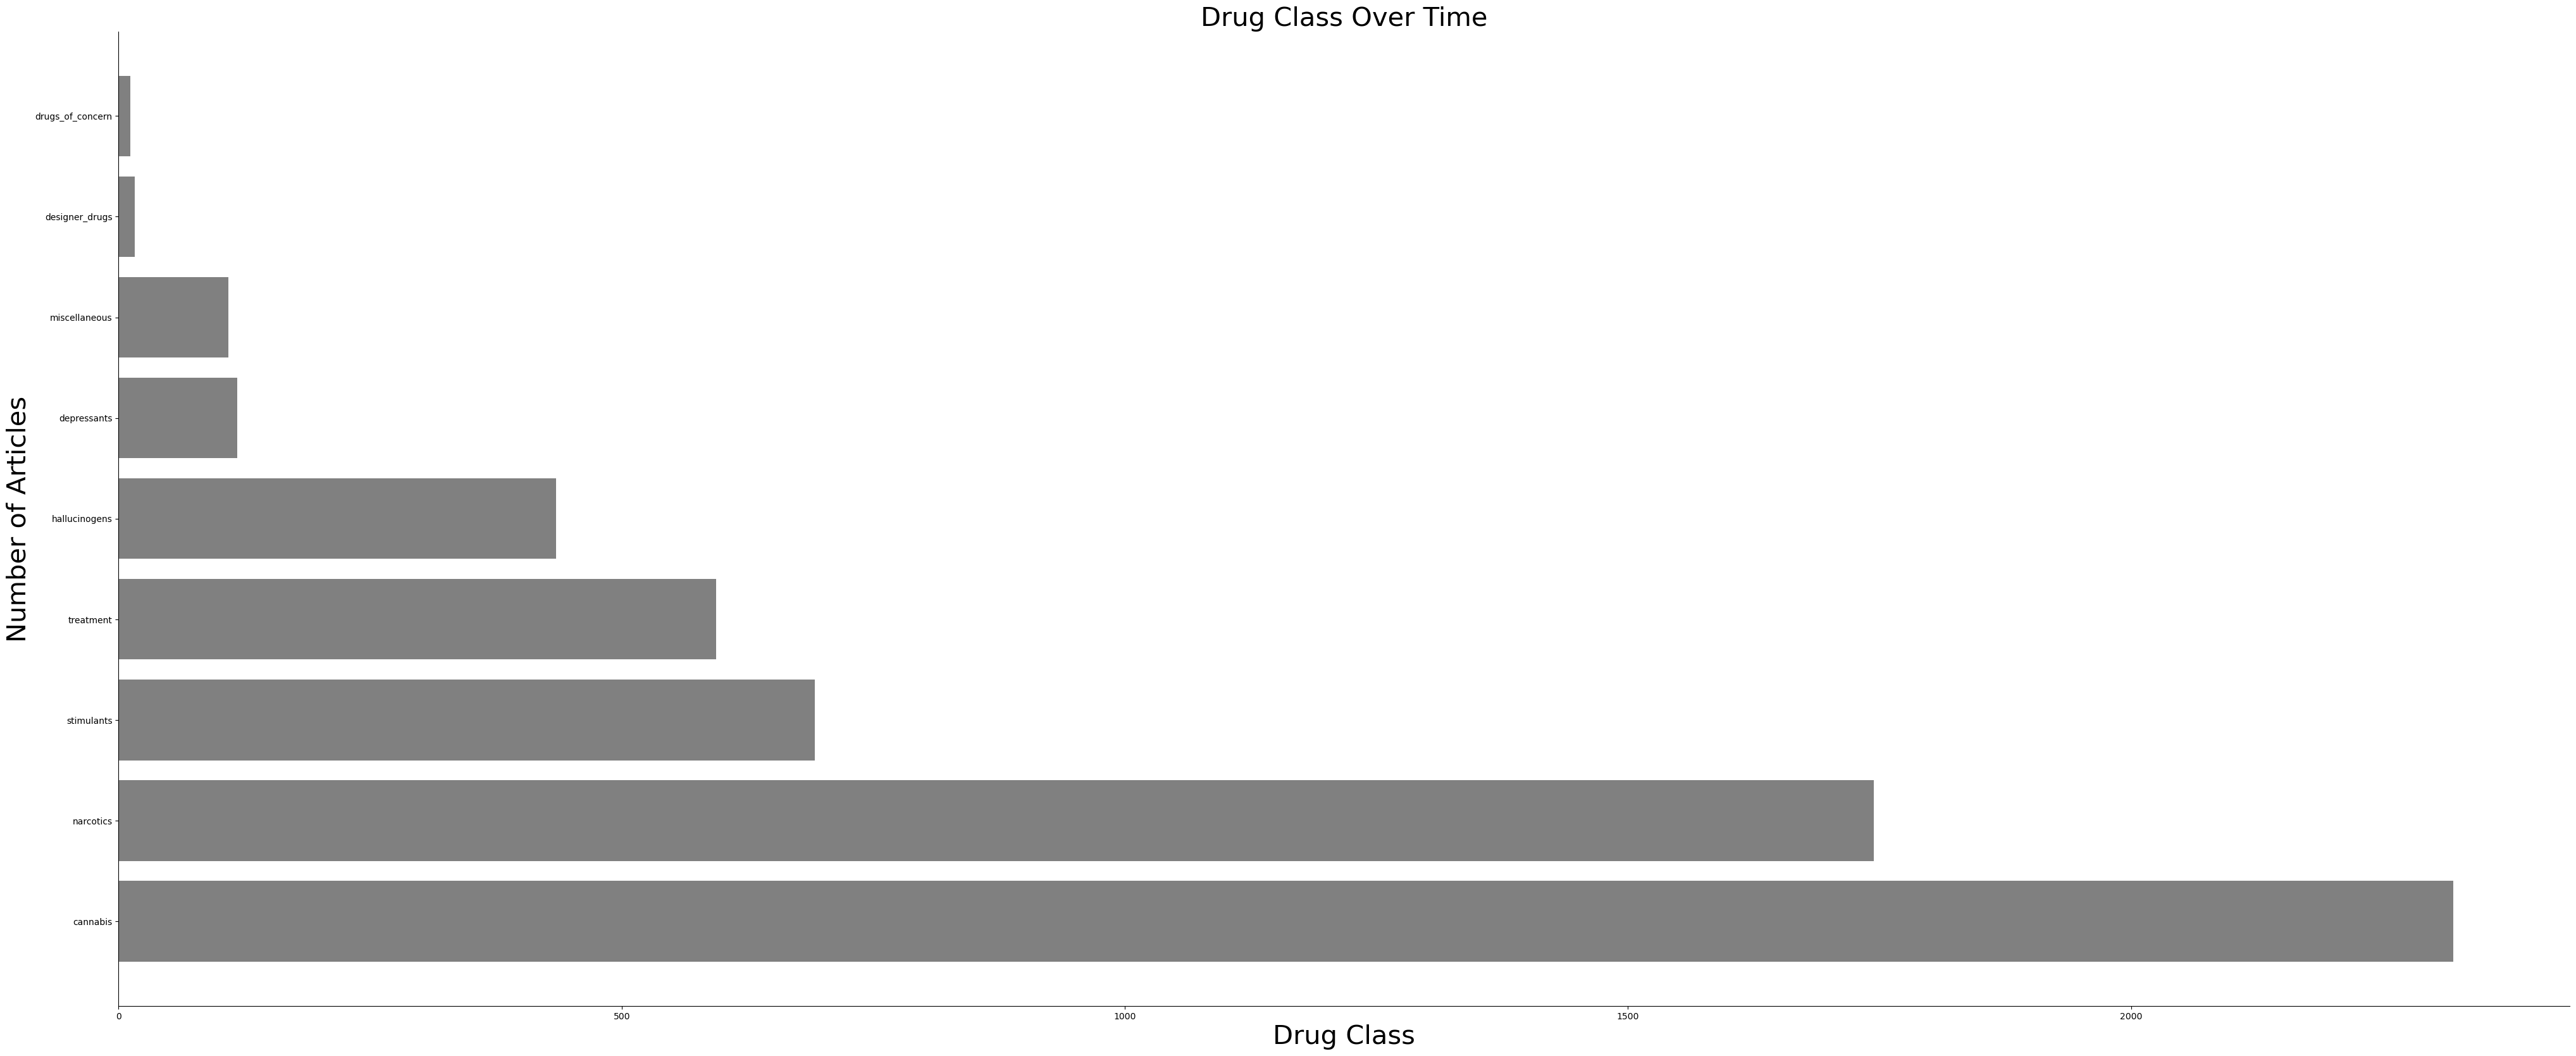

In [27]:
# plot frequency of classes
drug_class = drug_articles["drug_class"].explode().value_counts().sort_values(ascending=False)
# plot
fig, ax = plt.subplots(figsize=(50, 20))
# horizontal bar plot
ax.barh(drug_class.index, drug_class.values, color = "grey")
# remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# font size
plt.rc('xtick', labelsize=30)
plt.rc('ytick', labelsize=30)
# add y axis label
ax.set_xlabel("Drug Class", fontsize=30)
ax.set_ylabel("Number of Articles", fontsize=30)
ax.set_title("Drug Class Over Time", fontsize=30)
plt.show()


In [28]:
# table 1 
# years 2013-2023 as rows
# drug classes as columns
# values: number of articles, average word count

# Define the drug classes
drug_classes = ["stimulants", "hallucinogens", "depressants", "narcotics", "treatment", "designer_drugs", "cannabis", "drugs_of_concern"]
drug_classes = sorted(drug_classes)

# Define the years as a list of strings
years = [str(year) for year in range(2013, 2023)]

# Create an empty pandas dataframe to store the results
results = pd.DataFrame(columns=drug_classes, index=years)

# Loop over the years and drug classes, and compute the median article length and number of articles for each combination
for year in years:
    for drug_class in drug_classes:
        # Extract the articles for the current year and drug class from the corpus
        articles = drug_articles[(drug_articles["Date"].dt.year == int(year)) & (drug_articles["drug_class"].apply(lambda x: drug_class in x))]["Text"].tolist()
        # for article in drug_articles[drug_articles["Date"].dt.year == year]:
        #     if article["drug_class"] in drug_class:
        #         articles.append(article["Text"])
        
        # Compute the median article length and number of articles
        if articles:
            article_lengths = [len(article.split()) for article in articles]
            median_length = int(pd.Series(article_lengths).median())
            num_articles = len(articles)
        else:
            median_length = 0
            num_articles = 0
        
        # Store the results in the dataframe
        results.at[year, drug_class] = num_articles

    # get total number of articles with mean and std
    # total = results.loc[year].sum()
    # mean = results.loc[year].mean()
    # std = results.loc[year].std()
    # results.at[year, "total"] = total
    # results.at[year, "mean"] = (mean, std)
# get total of each drug class
# results.loc["total"] = results.sum()
# results.loc["mean"] = results.mean()
# results.loc["std"] = results.std()

# Print the results
print(results)


     cannabis depressants designer_drugs drugs_of_concern hallucinogens  \
2013      152          23              3                2            38   
2014      150          10              0                1            53   
2015      132           6              0                0            35   
2016      152          12              0                0            44   
2017      203          12              0                0            37   
2018      226          14              8                6            43   
2019      234          10              4                2            55   
2020      119           7              0                0            18   
2021      124           7              0                0            40   
2022      145           5              1                0            31   

     narcotics stimulants treatment  
2013       142        108        16  
2014       117         64        21  
2015       117         49        30  
2016       132        

In [29]:
# save to csv
results.to_csv("output/drug_class_over_time.csv")

In [30]:
# split column so that there is only one set per row
sankey_dat = drug_articles["class_drug"].explode()
sankey_dat.head()

1         (stimulants, cocaine)
36          (narcotics, heroin)
102    (narcotics, hydrocodone)
102      (narcotics, oxycodone)
169       (cannabis, marijuana)
Name: class_drug, dtype: object

In [31]:
# split tuple into two columns
sankey_dat = sankey_dat.apply(pd.Series)
# sankey_dat.head() 
sankey_dat.groupby(0).value_counts(normalize=True, ascending=True)

0            1            
cannabis     weed             0.144610
             cannabis         0.251972
             marijuana        0.603418
depressants  librium          0.008475
             lorazepam        0.008475
                                ...   
treatment    suboxone         0.088850
             buprenorphine    0.127178
             narcan           0.186411
             naloxone         0.266551
             methadone        0.301394
Length: 76, dtype: float64

In [33]:
# from pySankey.sankey import sankey

# reformat data for sankey
sankey_dat = sankey_dat.groupby(0).value_counts(ascending=True)
sankey_dat.head()

0            1        
cannabis     weed          330
             cannabis      575
             marijuana    1377
depressants  zaleplon        1
             lunesta         1
dtype: int64

In [34]:
sankey_dat = sankey_dat.reset_index(level = 1)
sankey_dat["drug_class"] = sankey_dat.index

In [39]:
# blah[0].apply(lambda x: x if x > 0.1 else "other")
sankey_dat.loc[sankey_dat[0] < 15, 1] = "other"
sankey_dat = sankey_dat[sankey_dat[1] != 'other']


In [41]:
sankey_dat.reset_index(drop=True, inplace=True)
sankey_dat.head()
sankey_dat.to_csv('./output/sankey_out.csv')


In [38]:
# create weights
# sankey_dat["weight"] = sankey_dat[0] * 100
# sankey_dat.head()

1         0   drug_class     weight
0       weed  0.144828     cannabis  14.482759
1   cannabis  0.253017     cannabis  25.301724
2  marijuana  0.602155     cannabis  60.215517
3      other  0.008475  depressants   0.847458
4      other  0.008475  depressants   0.847458

In [ ]:
# colors_classes = {
#     "cannabis": "#648FFF",
#     "narcotics": "#785EF0",
#     "hallucinogens": "#DC267F",
#     "stimulants": "#FE6100",
#     "depressants": "#FFB000",
#     "treatment": "#994F00",
#     "designer_drugs": "#1AFF1A",
#     "other": "#DC3220"
# }

# # sankey of class split to drugs within class, weighted by number of articles
# # per class, collapse the less frequent drugs into "other"

# sankey(
#     sankey_dat["drug_class"],
#     sankey_dat[1],
#     aspect=20,
#     fontsize=9,
#     leftWeight = sankey_dat["weight"],
#     rightWeight = sankey_dat["weight"]
# )

In [119]:
# export to csv
# sankey_dat.to_csv("output/sankey_dat.csv")

In [71]:
# sankey_dat["drug_class"].unique()

array(['cannabis', 'depressants', 'designer_drugs', 'hallucinogens',
       'miscellaneous', 'narcotics', 'stimulants', 'treatment'],
      dtype=object)

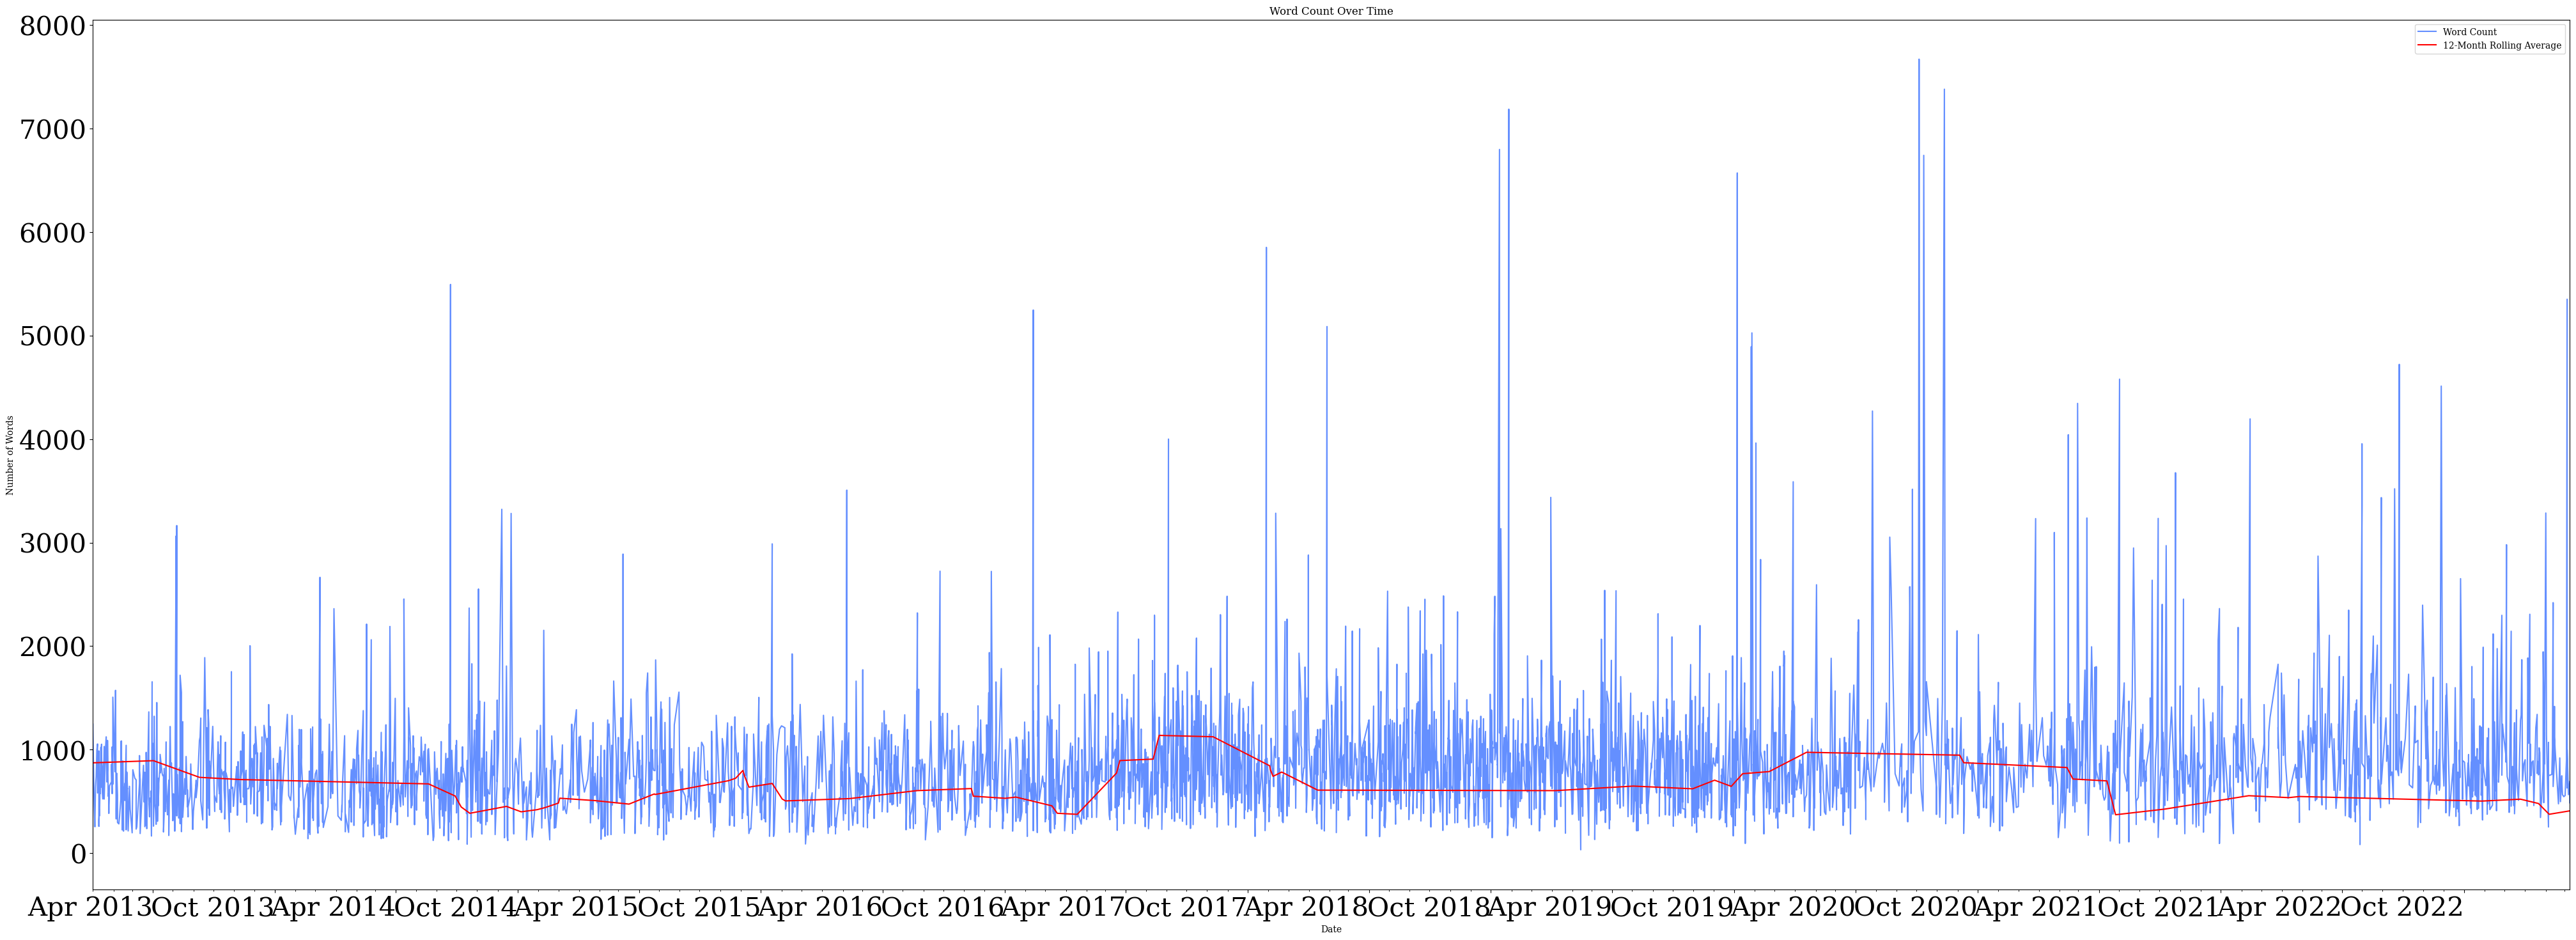

In [40]:
# count of al words over time
drug_articles["word_count"] = drug_articles["Text"].apply(lambda x: len(x.split()))

# plot word count over time
fig, ax = plt.subplots(figsize=(50, 20))
ax.plot(drug_articles["Date"], drug_articles["word_count"], label="Word Count", color = "#648FFF")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
# begin x axis at the first Date value
ax.set_xlim(drug_articles["Date"].iloc[0], drug_articles["Date"].iloc[-1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
# rotate and align the tick labels so they look better
fig.autofmt_xdate()

# rolling avg
drug_articles["word_count"].rolling(6).mean().plot(ax=ax, label="12-Month Rolling Average", color = "red")

ax.set_xlabel("Date")
ax.set_ylabel("Number of Words")
ax.set_title("Word Count Over Time")
ax.legend()
plt.show()

In [41]:
# average length of articles
print("Average length of articles: ", drug_articles["word_count"].mean())
print("Median length of articles: ", drug_articles["word_count"].median())
print("Standard Deviation of length of articles: ", drug_articles["word_count"].std())

Average length of articles:  844.4054121151936
Median length of articles:  750.0
Standard Deviation of length of articles:  571.5053175835953


---

### Co-mentions

In [42]:
# create dictionary of drug classes and drugs with elements of list
drug_dict = {
    "cannabis": cannabis,
    "narcotics": narcotics,
    "hallucinogens": hallucinogens,
    "stimulants": stimulants,
    "depressants": depressants,
    "treatment": treatment,
    "designer_drugs": designer_drugs,
    "drugs_of_concern": drugs_of_concern
}

In [112]:
# study how substances are co-mentioned

# create a list of all the drugs
drugs = list(set(drug_articles["matches"].explode()))

# get the frequency of co-occurrence of drugs
drug_cooccur = pd.DataFrame(columns=drugs, index=drugs)
drug_cooccur = drug_cooccur.fillna(0)

# loop over all the articles
for article in drug_articles["Text"]:
    # split the article into words
    words = article.split()
    # loop over all the words
    for word in words:
        # if the word is a drug
        if word in drugs:
            # print(word)
            # get the class of the word with drug_dict
            try:
                word_class = [key for key, value in drug_dict.items() if word in value][0]
            except:
                word_class = "other"
                continue
            # loop over all the words again
            for word2 in words:
                # print(word, word2)
                # if the word is a drug and not the same drug
                if word2 in drugs:
                    try:
                        word2_class = [key for key, value in drug_dict.items() if word2 in value][0]
                    except:
                        word2_class = "other"
                        continue
                    if word2 != word and word_class != word2_class:
                        # increment the count of co-occurrence
                        drug_cooccur.at[word, word2] += 1

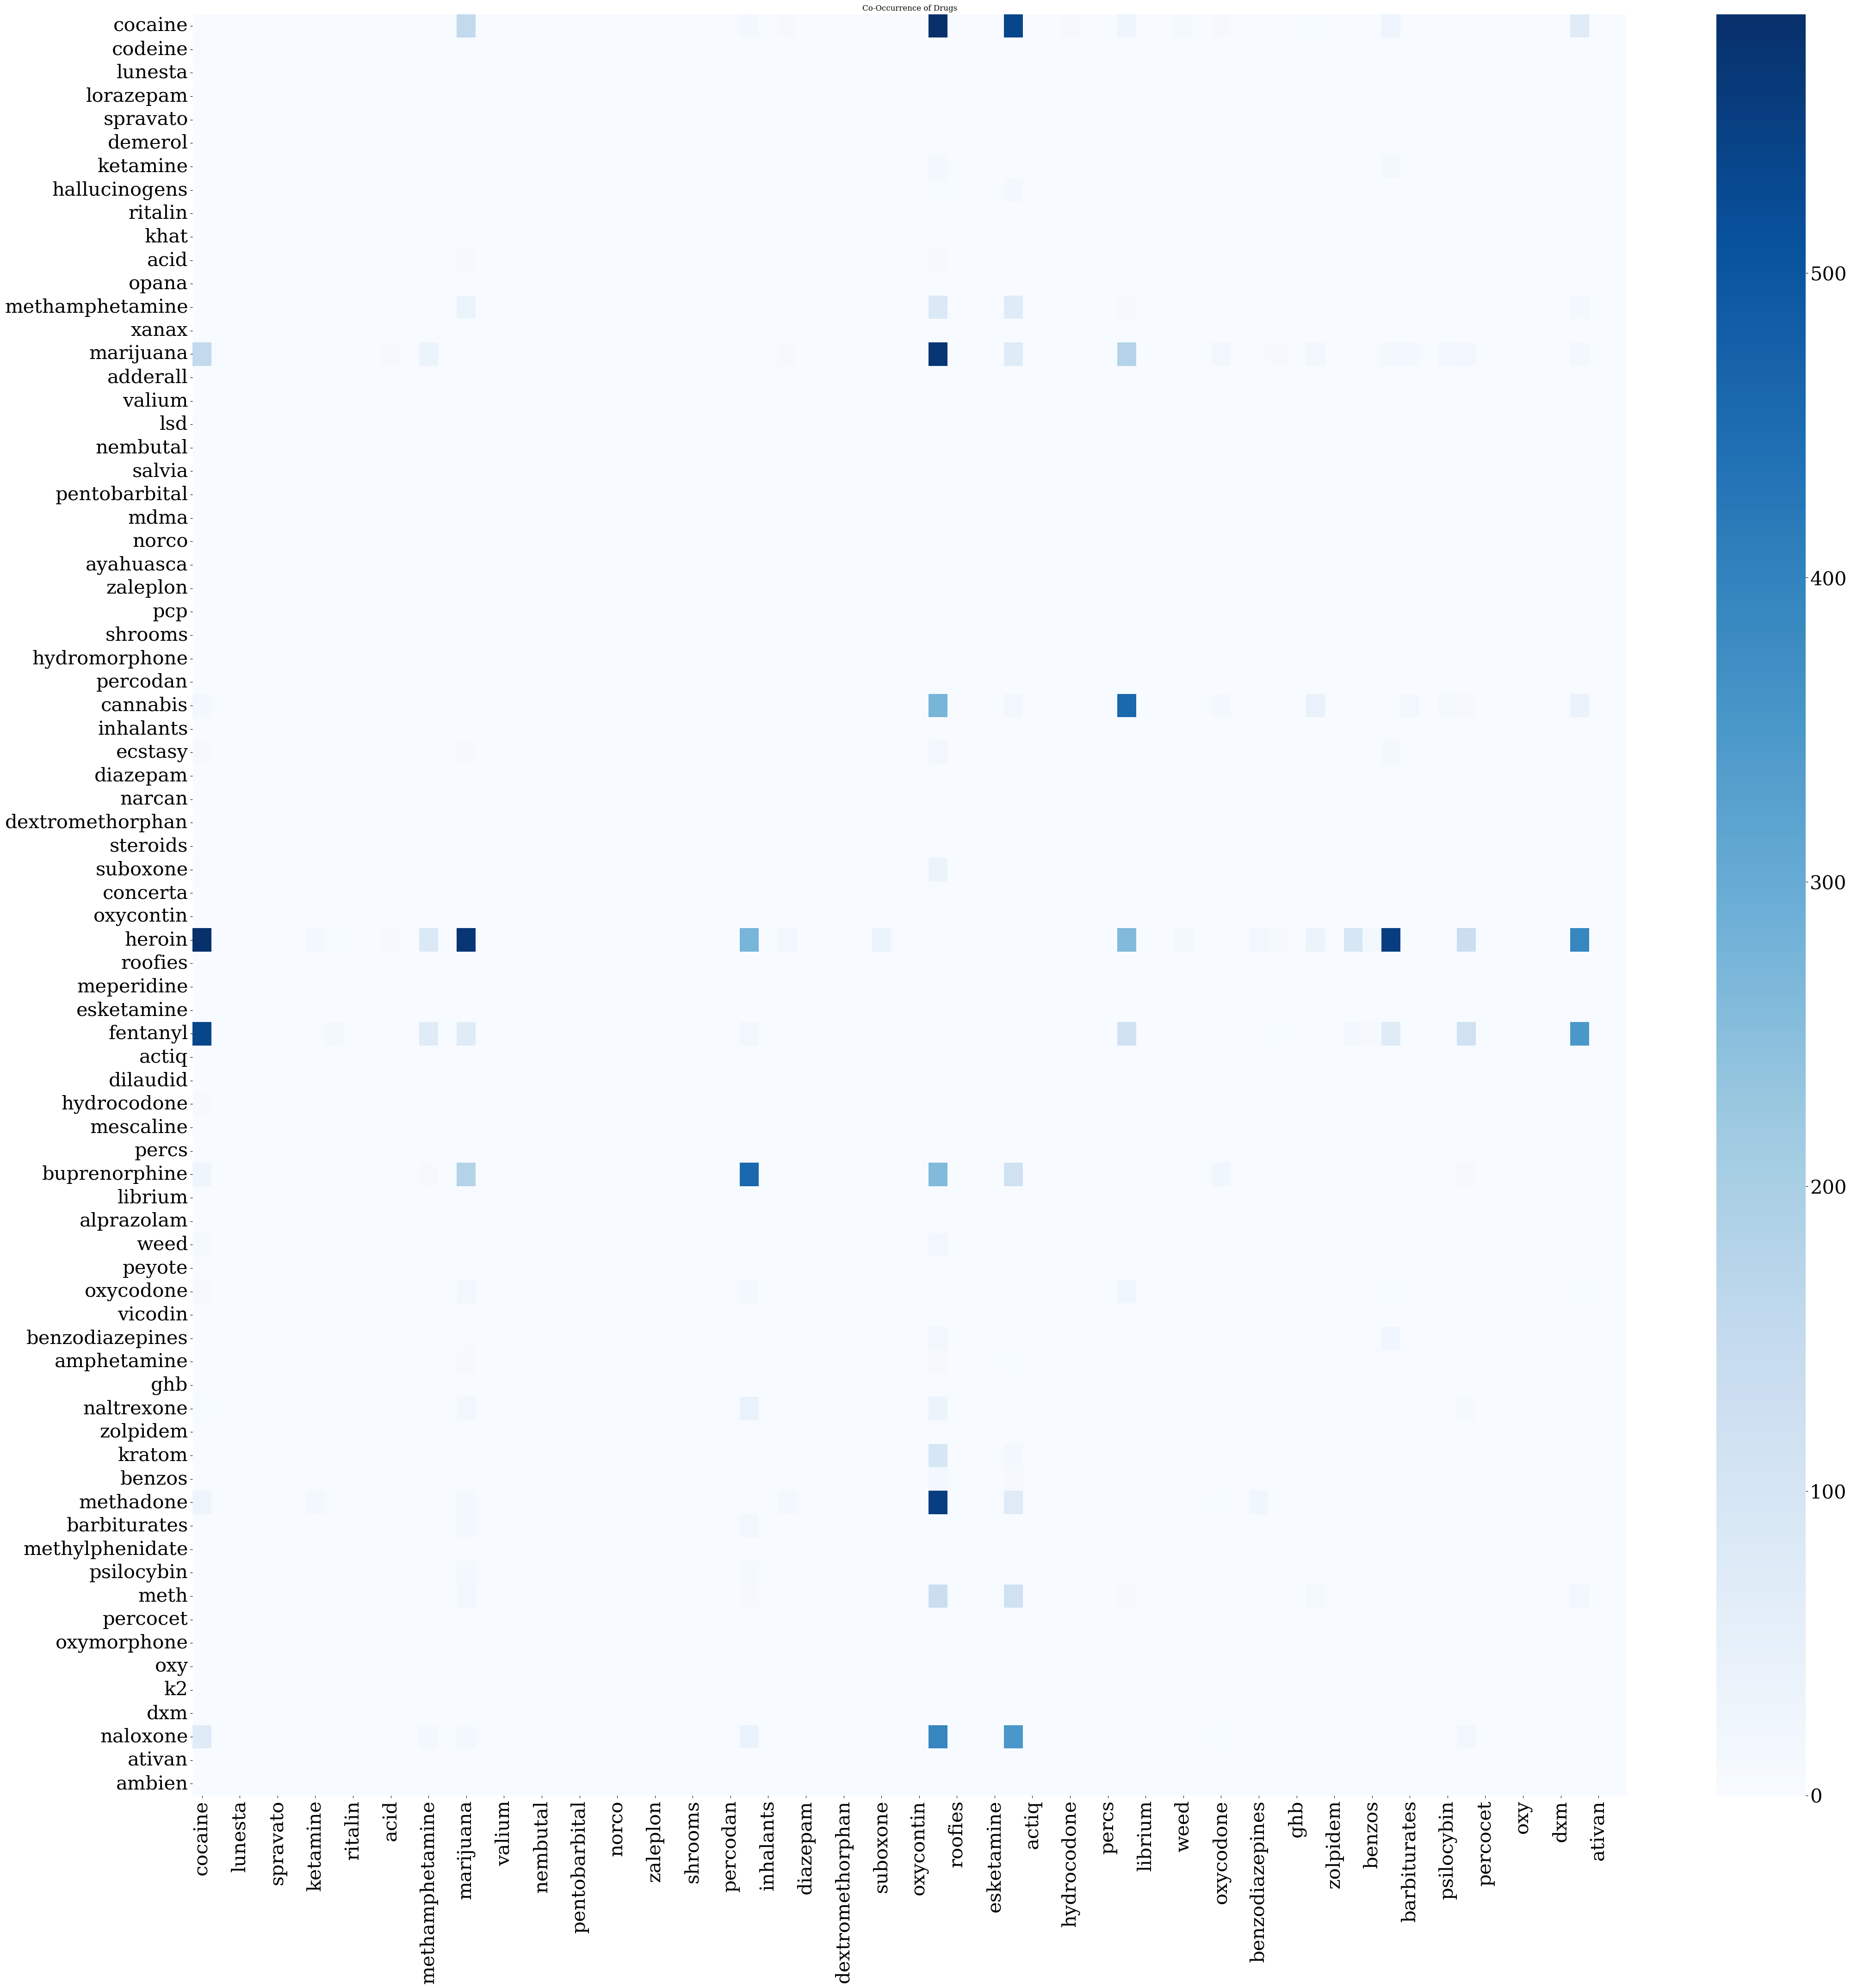

In [113]:
# plot co-occurrence of drugs
fig, ax = plt.subplots(figsize=(50, 50))
sns.heatmap(drug_cooccur, ax=ax, cmap="Blues")
ax.set_title("Co-Occurrence of Drugs")
plt.show()

In [86]:
print("The top 10 most co-occuring drug pairs are: \n", drug_cooccur.unstack().sort_values(ascending=False).head(10))

The top 10 most co-occuring drug pairs are: 
 heroin         cocaine          585
cocaine        heroin           585
marijuana      heroin           572
heroin         marijuana        572
methadone      heroin           552
heroin         methadone        552
cocaine        fentanyl         537
fentanyl       cocaine          537
cannabis       buprenorphine    459
buprenorphine  cannabis         459
dtype: int64


In [46]:
# co-occurance per year
drug_cooccur_year = pd.DataFrame(columns=drugs, index=drugs)
drug_cooccur_year["year"] = ""
drug_cooccur_year = drug_cooccur_year.fillna(0)
# add year
def get_coocur(year):
    # get the frequency of co-occurrence of drugs
    drug_cooccur = pd.DataFrame(columns=drugs, index=drugs)
    drug_cooccur = drug_cooccur.fillna(0)
    # loop over all the articles
    for article in drug_articles[drug_articles["Date"].dt.year == year]["Text"]:
        # split the article into words
        words = article.split()
        # loop over all the words
        for word in words:
            # if the word is a drug
            if word in drugs:
                # print(word)
                # get the class of the word with drug_dict
                try:
                    word_class = [key for key, value in drug_dict.items() if word in value][0]
                except:
                    word_class = "other"
                    continue
                # loop over all the words again
                for word2 in words:
                    # print(word, word2)
                    # if the word is a drug and not the same drug
                    if word2 in drugs:
                        try:
                            word2_class = [key for key, value in drug_dict.items() if word2 in value][0]
                        except:
                            word2_class = "other"
                            continue
                        if word2 != word and word_class != word2_class:
                            # increment the count of co-occurrence
                            drug_cooccur.at[word, word2] += 1
    drug_cooccur["year"] = year
    return drug_cooccur


In [47]:
drug_cooccur_year = pd.concat([get_coocur(year) for year in range(2013, 2023)])

In [48]:
print("The top 10 most co-occuring drugs per year are: \n", 
"in 2013: \n", drug_cooccur_year[drug_cooccur_year["year"] == 2013].iloc[:, :-1].unstack().sort_values(ascending=False).head(10),
"in 2014: \n", drug_cooccur_year[drug_cooccur_year["year"] == 2014].iloc[:, :-1].unstack().sort_values(ascending=False).head(10),
"in 2015: \n", drug_cooccur_year[drug_cooccur_year["year"] == 2015].iloc[:, :-1].unstack().sort_values(ascending=False).head(10),
"in 2016: \n", drug_cooccur_year[drug_cooccur_year["year"] == 2016].iloc[:, :-1].unstack().sort_values(ascending=False).head(10),
"in 2017: \n", drug_cooccur_year[drug_cooccur_year["year"] == 2017].iloc[:, :-1].unstack().sort_values(ascending=False).head(10),
"in 2018: \n", drug_cooccur_year[drug_cooccur_year["year"] == 2018].iloc[:, :-1].unstack().sort_values(ascending=False).head(10),
"in 2019: \n", drug_cooccur_year[drug_cooccur_year["year"] == 2019].iloc[:, :-1].unstack().sort_values(ascending=False).head(10),
"in 2020: \n", drug_cooccur_year[drug_cooccur_year["year"] == 2020].iloc[:, :-1].unstack().sort_values(ascending=False).head(10),
"in 2021: \n", drug_cooccur_year[drug_cooccur_year["year"] == 2021].iloc[:, :-1].unstack().sort_values(ascending=False).head(10),
"in 2022: \n", drug_cooccur_year[drug_cooccur_year["year"] == 2022].iloc[:, :-1].unstack().sort_values(ascending=False).head(10))


The top 10 most co-occuring drugs per year are: 
 in 2013: 
 methadone     heroin          52
heroin        methadone       52
cocaine       heroin          45
heroin        cocaine         45
cannabis      barbiturates    16
barbiturates  cannabis        16
              marijuana       14
marijuana     barbiturates    14
cocaine       marijuana        7
marijuana     cocaine          7
dtype: int64 in 2014: 
 naloxone   heroin       42
heroin     naloxone     42
marijuana  cocaine      36
cocaine    marijuana    36
           heroin       34
heroin     cocaine      34
marijuana  heroin       20
heroin     marijuana    20
fentanyl   cocaine       8
naloxone   fentanyl      8
dtype: int64 in 2015: 
 heroin           marijuana          40
marijuana        heroin             40
heroin           methadone          19
methadone        heroin             19
heroin           meth               11
meth             heroin             11
heroin           methamphetamine     8
                 c

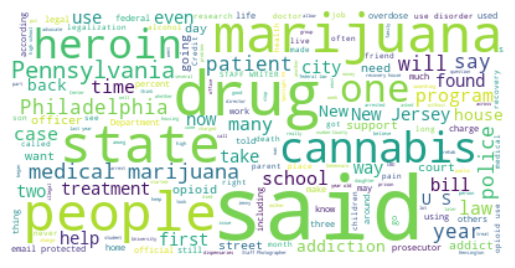

In [49]:
# subset articles only talking about marijuana and heroin
marijuana_heroin_articles = drug_articles[drug_articles["matches"].apply(lambda x: "marijuana" in x and "heroin" in x)]
marijuana_heroin_articles_wc = marijuana_heroin_articles["Text"].str.cat(sep=" ")

# create word cloud
wc = WordCloud(stopwords=STOPWORDS, background_color="white").generate(marijuana_heroin_articles_wc)
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


In [50]:
# which words are most weigthed in the articles
# tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def get_top_words(text_df):
    # create tf-idf vectorizer
    vectorizer = TfidfVectorizer(stop_words=STOPWORDS, max_features=1000)
    # fit the vectorizer
    vectorizer.fit(text_df["Text"])
    # get the feature names
    feature_names = vectorizer.get_feature_names()
    # get the tf-idf scores
    tfidf_scores = vectorizer.transform(text_df["Text"])
    # get the top 10 words
    top_words = np.argsort(tfidf_scores.toarray()).flatten()[::-1][:10]
    # print the top 10 words
    print("The top 10 words are: \n", [feature_names[i] for i in top_words])

get_top_words(marijuana_heroin_articles)

The top 10 words are: 
 ['fentanyl', 'products', 'said', 'sold', 'montgomery', 'illicit', 'thc', 'positive', 'synthetic', 'county']


/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(
/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


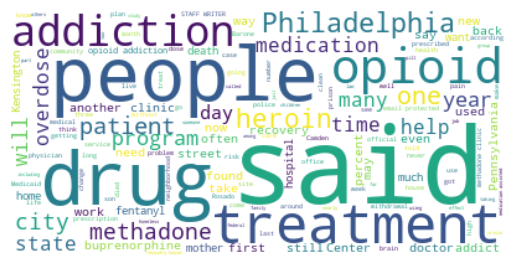

In [51]:
heroin_methadone = drug_articles[drug_articles["matches"].apply(lambda x: "heroin" in x and "methadone" in x)]
heroin_methadone_wc = heroin_methadone["Text"].str.cat(sep=" ")

# create word cloud
wc = WordCloud(stopwords=STOPWORDS, background_color="white").generate(heroin_methadone_wc)
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [52]:
get_top_words(heroin_methadone)

The top 10 words are: 
 ['jail', 'camden', 'medicaid', 'use', 'funding', 'county', 'prisons', 'treatment', 'state', 'states']


/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(
/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


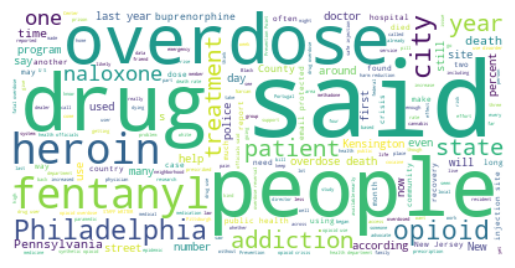

In [53]:
heroin_naloxone = drug_articles[drug_articles["matches"].apply(lambda x: "heroin" in x and "naloxone" in x)]
heroin_naloxone_wc = heroin_naloxone["Text"].str.cat(sep=" ")

# create word cloud
wc = WordCloud(stopwords=STOPWORDS, background_color="white").generate(heroin_naloxone_wc)
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [54]:
get_top_words(heroin_naloxone)

The top 10 words are: 
 ['crime', 'bill', 'jersey', 'new', 'drugs', 'people', 'use', 'proposed', 'prison', 'fentanyl']


/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(
/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


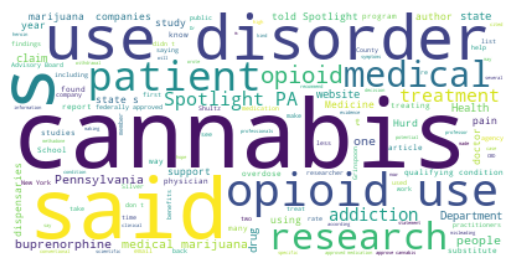

In [55]:
bup_cannabis = drug_articles[drug_articles["matches"].apply(lambda x: "buprenorphine" in x and "cannabis" in x)]
bup_cannabis_wc = bup_cannabis["Text"].str.cat(sep=" ")

# create word cloud
wc = WordCloud(stopwords=STOPWORDS, background_color="white").generate(bup_cannabis_wc)
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [56]:
get_top_words(bup_cannabis)

The top 10 words are: 
 ['cannabis', 'medical', 'said', 'opioid', 'use', 'disorder', 'pa', 'marijuana', 'spotlight', 'patients']


/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(
/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


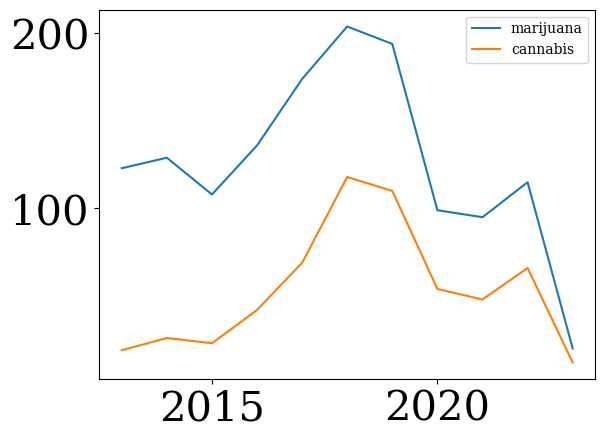

In [116]:
# compare the use of the words "marijuana" and "cannabis" over time
marijuana_cannabis = drug_articles[drug_articles["matches"].apply(lambda x: "marijuana" in x or "cannabis" in x)]
marijuana_cannabis["year"] = marijuana_cannabis["Date"].apply(lambda x: x.year)
marijuana_cannabis["marijuana"] = marijuana_cannabis["matches"].apply(lambda x: "marijuana" in x)
marijuana_cannabis["cannabis"] = marijuana_cannabis["matches"].apply(lambda x: "cannabis" in x)
marijuana_cannabis = marijuana_cannabis.groupby("year").sum().reset_index()
# plot
plt.plot(marijuana_cannabis["year"], marijuana_cannabis["marijuana"], label="marijuana")
plt.plot(marijuana_cannabis["year"], marijuana_cannabis["cannabis"], label="cannabis")
plt.legend()
plt.show()


In [125]:
get_top_words(high_drugs)

The top 10 words are: 
 ['phillies', 'eagles', 'game', 'season', 'coach', 'manager', 'games', 'win', 'first', 'points']


---

## Topic Modeling

Topic model per class: https://maartengr.github.io/BERTopic/getting_started/topicsperclass/topicsperclass.html

In [93]:
del topic_model

In [43]:
import spacy
from bertopic import BERTopic
nlp = spacy.load('en_core_web_md', exclude=['tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer'])

# join for bertopic
drug_articles["clean_text_str"] = drug_articles["clean_text"].apply(lambda x: " ".join(x))


In [95]:
from sklearn.decomposition import PCA

# dim_model = PCA(n_components=10)
topic_model = BERTopic(embedding_model=nlp, calculate_probabilities=True, verbose=True, top_n_words=10, n_gram_range=(1,2))
topics, probs = topic_model.fit_transform(drug_articles["clean_text_str"])


100%|██████████| 4028/4028 [03:18<00:00, 20.30it/s]
2023-04-08 13:17:28,573 - BERTopic - Transformed documents to Embeddings
2023-04-08 13:17:40,125 - BERTopic - Reduced dimensionality
2023-04-08 13:17:40,716 - BERTopic - Clustered reduced embeddings


In [96]:
topic_model.get_topic_info()

Topic  Count                                           Name
0      -1   1341               -1_said_drug_people_philadelphia
1       0    194               0_patients_treatment_opioid_said
2       1    188                    1_marijuana_bill_said_state
3       2    159                          2_said_it_people_like
4       3    146                      3_eagles_season_game_team
..    ...    ...                                            ...
56     55     11                    55_hops_farm_biochar_plants
57     56     11              56_grabowski_dewey_library_kanbar
58     57     11            57_marijuana_desilvio_cannabis_said
59     58     11                58_mcnew_kauffman_zysk_morrisey
60     59     10  59_dispensary_patients_marijuana_dispensaries

[61 rows x 3 columns]

In [97]:
topic_model.get_topic(1)

[('marijuana', 0.019437411019739472),
 ('bill', 0.014127378770311137),
 ('said', 0.013125363887675798),
 ('state', 0.011787844095842619),
 ('legalization', 0.008619590654394878),
 ('new', 0.008592013636517994),
 ('law', 0.008301561367371703),
 ('jersey', 0.008075915106860303),
 ('new jersey', 0.00773481020140787),
 ('medical', 0.00756018054372589)]

In [61]:
topic_model.save("output/models/topic_model")

In [98]:
fig = topic_model.visualize_topics()
fig.show()

In [99]:
# top 5 topics
topic_model.visualize_barchart(top_n_topics=5)

In [64]:
# hierarchical
topic_model.visualize_hierarchy()

In [100]:
docs = drug_articles["clean_text_str"]
classes = drug_articles["drug_class"].apply(lambda x: x[0])

In [66]:
topics_per_class = topic_model.topics_per_class(docs, classes = classes)

9it [00:10,  1.21s/it]


In [67]:
topic_model.visualize_topics_per_class(topics_per_class, top_n_topics=10)

In [68]:
timestamps = drug_articles.Date.to_list()
topics_over_time = topic_model.topics_over_time(docs, timestamps, nr_bins=20)

20it [05:40, 17.02s/it]


In [69]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=20)

In [101]:
# save topic model
topic_model.save("output/models/topic_model_1")

articles on opioid overdose peaked around 2019 and then started to decline. all topics declined from 2020 bc of the pandemic. but we see a spike in marijuana related articles. marijuana articles continues to be more frequent over other topics however we see there is an emergence in articles on xylaxine - a veternary tranquilizer currently impacting those suffering from SUD in Philadelphia.

---

### Reduce topics and optimize

In [102]:
# Further reduce topics
topice_model_red1 = topic_model.reduce_topics(drug_articles["clean_text_str"], nr_topics="8")

# Access updated topics
topics2 = topic_model.topics_

2023-04-08 13:20:27,675 - BERTopic - Reduced number of topics from 61 to 38


In [103]:
fig = topice_model_red1.visualize_topics()
fig.show()

In [104]:
# get the topics
topice_model_red1.get_topic_info()


Topic  Count                                               Name
0      -1   1341                   -1_said_drug_people_philadelphia
1       0    414                     0_marijuana_state_said_medical
2       1    341                       1_said_drug_treatment_opioid
3       2    327                              2_said_people_it_like
4       3    230                      3_police_said_man_police said
5       4    229                           4_said_police_court_case
6       5    146                          5_eagles_season_game_team
7       6    136                      6_city_said_people_kensington
8       7    126                     7_drug_said_authorities_heroin
9       8     79              8_campaign_said_democratic_republican
10      9     76                        9_movie_stars_directed_mins
11     10     65               10_million_endo_company_pennsylvania
12     11     51                      11_water_refinery_solvay_pfna
13     12     46               12_deaths_percent_overdose_overdoses
14     13     37                 13_people_city_safe injection_safe
15     14     30                           14_music_rock_album_band
16     15     29   15_insurance_letters_life insurance_philadelphia
17     16     24                      16_fetterman_oz_campaign_said
18     17     24                             17_dr_mr_he_university
19     18     21                      18_music_wainwright_song_says
20     19     20                            19_grams_cup_sauce_salt
21     20     18                        20_trees_pollen_plants_tree
22     21     18                         21_said_toohil_white_trump
23     22     17                    22_fentanyl_use_overdose_opioid
24     23     16  23_says_tells_derakhshani illustration_credit ...
25     24     15                         24_kratom_cbd_fda_products
26     25     15              25_panel_medical_marijuana_conditions
27     26     14                       26_hemp_cbd_cannabis_whaling
28     27     13                           27_guns_gun_stolen_ahmad
29     28     13                    28_devereux_children_said_child
30     29     13                  29_percent_voters_republican_poll
31     30     13                       30_dhs_glen mills_glen_mills
32     31     13                       31_napier_buckman_said_paulk
33     32     13                         32_tax_murphy_budget_taxes
34     33     12                 33_ccf_dispensary_marijuana_liquor
35     34     11                        34_hops_farm_biochar_plants
36     35     11                    35_grabowski_dewey_library_said
37     36     11                        36_mcnew_kauffman_said_zysk

In [74]:
topics_over_time = topice_model_red1.topics_over_time(docs, timestamps, nr_bins=20)

20it [05:48, 17.41s/it]


In [ ]:
dic = {0: "Cannabis: medical uses, crimes, and policies",
    1: "Media and entertainment news in popular culture",
    2: "Cannabis gardens, and water contaminations",
    3: "Sports and atheletes (Basketball, Baseball, etc.)",
    4: "Local news and obituaries",
    5: "Drug conviction and deportation",
    6: "Gun-related crimes and violence"}
topice_model_red1.set_topic_labels(dic)
topice_model_red1.custom_labels_

In [105]:
# visualize topics over time
topice_model_red1.visualize_topics_over_time(topics_over_time, top_n_topics=10)

In [106]:
# reduce topics to around 8

topice_model_red2 = topice_model_red1.reduce_topics(drug_articles["clean_text_str"], nr_topics=10)


2023-04-08 13:29:50,478 - BERTopic - Reduced number of topics from 38 to 10


In [107]:
fig = topice_model_red2.visualize_topics()
fig.show()

In [108]:
# per class topics
topice_model_red2.topics_per_class(docs, classes = classes)

# get the topics
topice_model_red2.get_topic_info()

9it [00:10,  1.19s/it]


Topic  Count                              Name
0     -1   1341  -1_said_people_drug_philadelphia
1      0   2208      0_said_people_marijuana_drug
2      1    146         1_season_eagles_game_team
3      2    127           2_music_like_movie_time
4      3    100      3_water_said_refinery_solvay
5      4     29            4_hemp_cbd_kratom_said
6      5     24             5_dr_mr_he_university
7      6     24      6_fetterman_oz_said_campaign
8      7     16    7_says_tells_new_credit tirdad
9      8     13       8_napier_said_buckman_paulk

In [109]:
topice_model_red2.visualize_topics_per_class(topics_per_class)

In [110]:
topics_over_time_red2 = topics_over_time_red2.topics_over_time(docs, timestamps, nr_bins=20)

20it [11:10, 33.52s/it]


In [ ]:
topics_over_time_red2.visualize_topics_over_time(topics_over_time, top_n_topics=20)

---

### All_articles topic modeling

In [ ]:
articles_df["clean_text"] = articles_df["clean_text"].apply(lambda x: " ".join(x))
topic_model_all_articles = BERTopic(embedding_model=nlp, calculate_probabilities=True, verbose=True, top_n_words=10, min_topic_size=15, n_gram_range=(1,2), low_memory=True)
topics_all_articles, probs_all_articles = topic_model_all_articles.fit_transform(articles_df["clean_text"])

100%|██████████| 159949/159949 [1:48:36<00:00, 24.54it/s]  
2023-04-04 12:12:34,504 - BERTopic - Transformed documents to Embeddings
2023-04-04 12:13:19,182 - BERTopic - Reduced dimensionality
2023-04-04 13:23:30,374 - BERTopic - Clustered reduced embeddings


In [ ]:
# save model
topic_model_all_articles.save("output/models/bertopic_all_articles")

/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


---

## Sentiment Analysis of articles over time

Sentiment analysis: You can use sentiment analysis to analyze the tone of drug news articles over time. This technique can help you identify shifts in public opinion towards certain drugs and the pharmaceutical industry.

In [46]:
import nltk
# nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta

# 6 month timeframes
# split data into 6 month intervals
# get the sentiment for each article in each interval
# get the average sentiment for each interval
# plot the average sentiment over time

# get the dates
dates = drug_articles["Date"].unique()

# get the sentiment for each article
sid = SentimentIntensityAnalyzer()
drug_articles["sentiment"] = drug_articles["Text"].apply(lambda x: sid.polarity_scores(x)["compound"])


In [47]:
# make dataframe of sentiment scores
sentiment_scores = pd.DataFrame()
sentiment_scores["Date"] = drug_articles["Date"]
sentiment_scores["sentiment"] = drug_articles["sentiment"]
sentiment_scores = sentiment_scores.groupby(pd.Grouper(key='Date', freq='6M')).mean().reset_index()
# sentiment_scores.groupby(pd.Grouper(key='Date', freq='6M')).mean().reset_index()



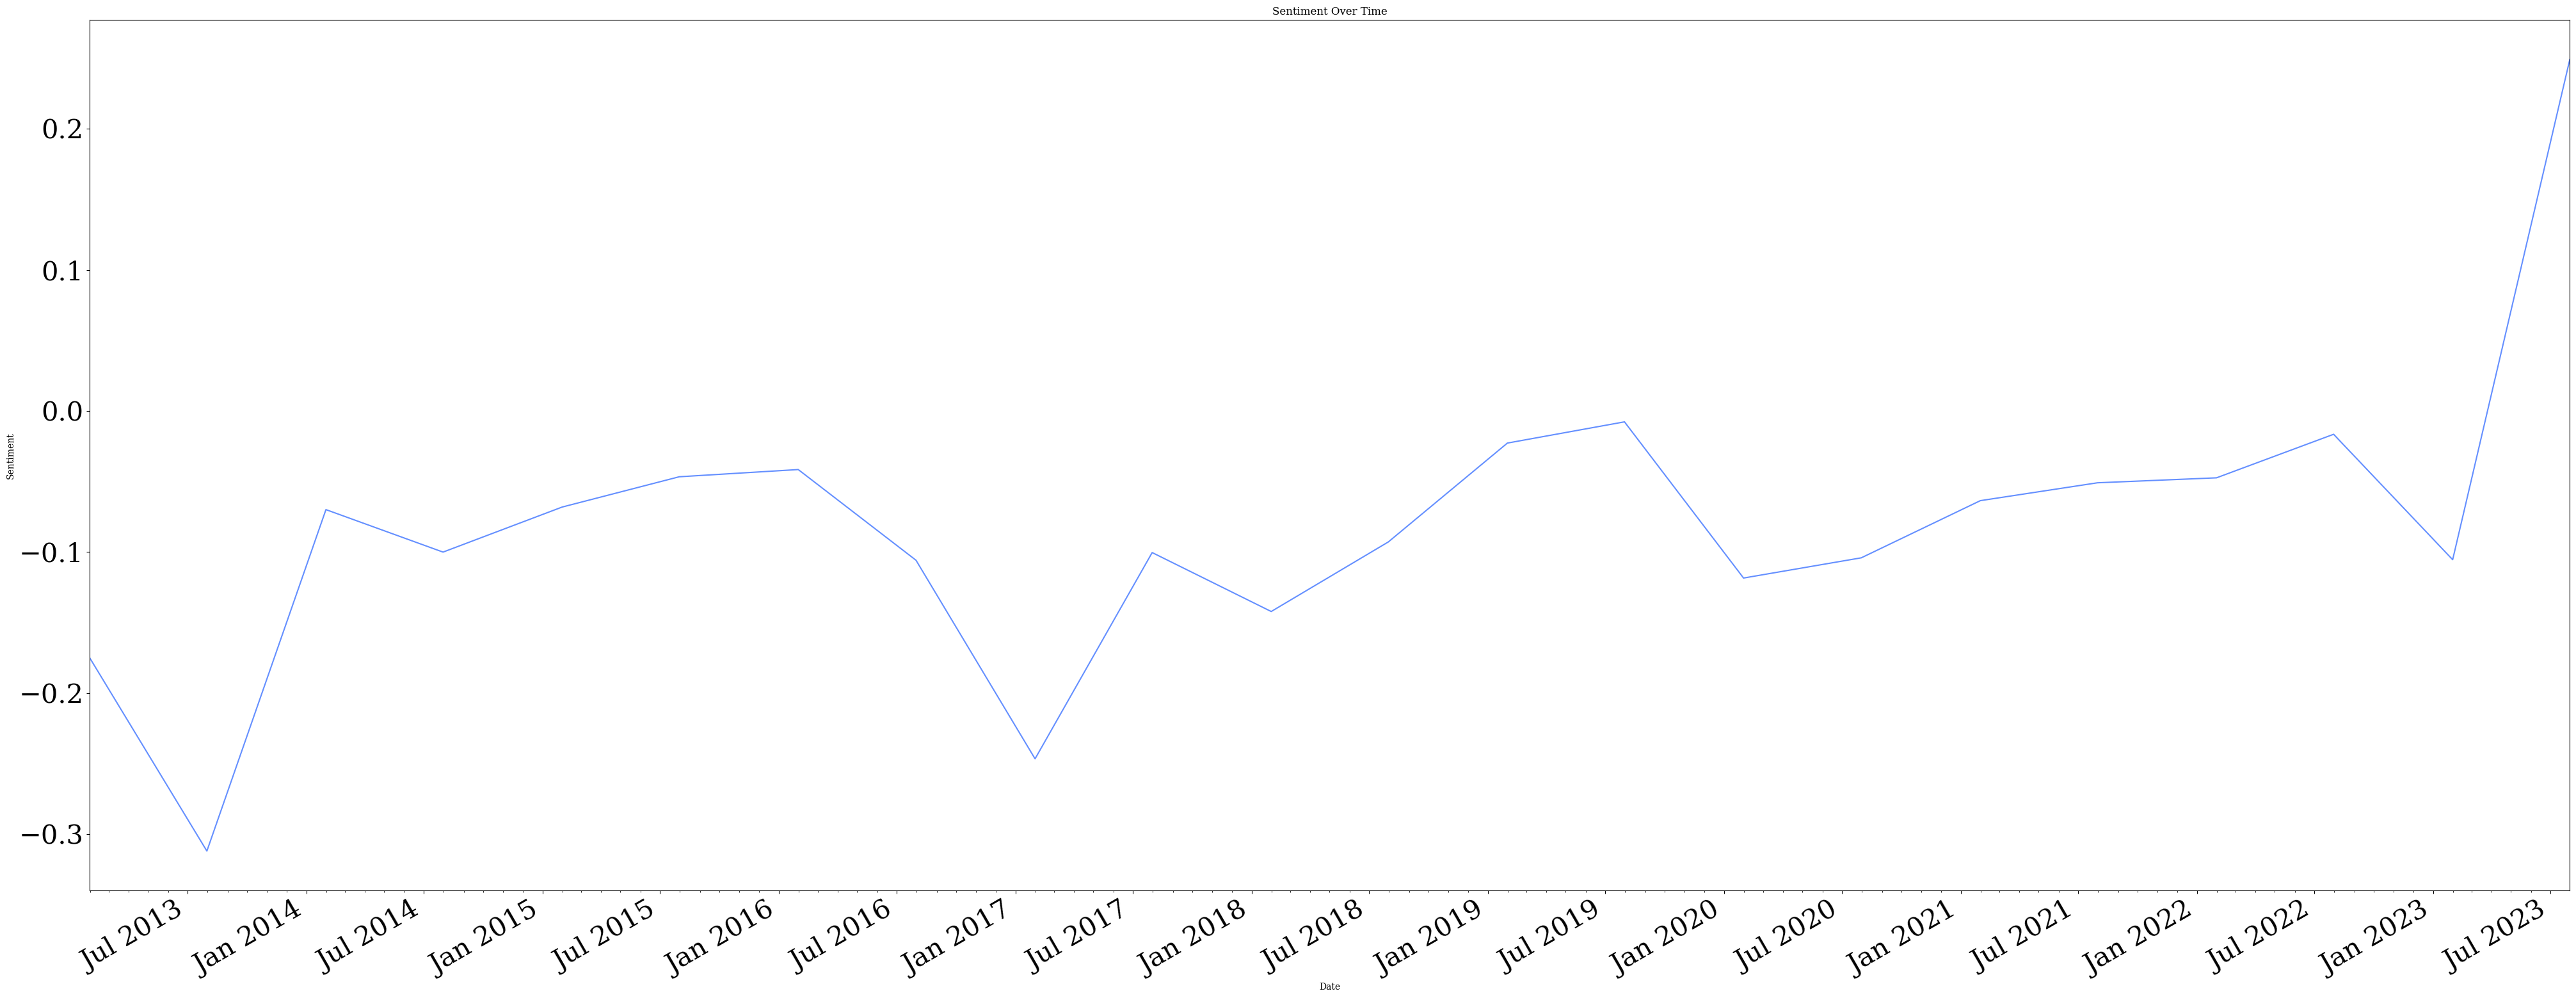

In [84]:
# visualize sentiment over time
fig, ax = plt.subplots(figsize=(50, 20))
ax.plot(sentiment_scores["Date"], sentiment_scores["sentiment"], label="Sentiment", color = "#648FFF")
# set x axis to be every 6 months
ax.set_xlim(sentiment_scores["Date"].iloc[0], sentiment_scores["Date"].iloc[-1])
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
# rotate and align the tick labels so they look better
fig.autofmt_xdate()

ax.set_xlabel("Date")
ax.set_ylabel("Sentiment")
ax.set_title("Sentiment Over Time")

plt.show()


In [48]:
drug_articles['year']=drug_articles['Date'].astype(str)
drug_articles['year'] = drug_articles['year'].apply(lambda x: x.split('-')[0])
drug_articles = drug_articles[drug_articles["year"] != "2023"]
sent_class = drug_articles[["drug_class", "sentiment", "year", "Text"]].explode("drug_class").reset_index(drop=True)
cannabis_sent_classes = sent_class[sent_class["drug_class"]=='cannabis']
depress_sent_classes = sent_class[sent_class["drug_class"]=='depressants']
designer_sent_classes = sent_class[sent_class["drug_class"]=='designer_drugs']
drugs_of_sent_classes = sent_class[sent_class["drug_class"]=='drugs_of_concern']
stimulants_sent_classes = sent_class[sent_class["drug_class"]=='stimulants']
treatment_sent_classes = sent_class[sent_class["drug_class"]=='treatment']
narcotics_sent_classes = sent_class[sent_class["drug_class"]=='narcotics']
miscellaneous_sent_classes = sent_class[sent_class["drug_class"]=='miscellaneous']
hallucinogens_sent_classes = sent_class[sent_class["drug_class"]=='hallucinogens']

In [49]:
cannabis_sent_classes = cannabis_sent_classes.groupby(["year","drug_class"])["sentiment"].mean()
depress_sent_classes = depress_sent_classes.groupby(["year","drug_class"])["sentiment"].mean()
designer_sent_classes = designer_sent_classes.groupby(["year","drug_class"])["sentiment"].mean()
drugs_of_sent_classes = drugs_of_sent_classes.groupby(["year","drug_class"])["sentiment"].mean()
stimulants_sent_classes = stimulants_sent_classes.groupby(["year","drug_class"])["sentiment"].mean()
treatment_sent_classes = treatment_sent_classes.groupby(["year","drug_class"])["sentiment"].mean()
narcotics_sent_classes = narcotics_sent_classes.groupby(["year","drug_class"])["sentiment"].mean()
miscellaneous_sent_classes = miscellaneous_sent_classes.groupby(["year","drug_class"])["sentiment"].mean()
hallucinogens_sent_classes = hallucinogens_sent_classes.groupby(["year","drug_class"])["sentiment"].mean()


In [50]:
cannabis_sent_classes = cannabis_sent_classes.reset_index()
depress_sent_classes = depress_sent_classes.reset_index()
designer_sent_classes = designer_sent_classes.reset_index()
drugs_of_sent_classes = drugs_of_sent_classes.reset_index()
stimulants_sent_classes = stimulants_sent_classes.reset_index()
treatment_sent_classes = treatment_sent_classes.reset_index()
narcotics_sent_classes = narcotics_sent_classes.reset_index()
miscellaneous_sent_classes = miscellaneous_sent_classes.reset_index()
hallucinogens_sent_classes = hallucinogens_sent_classes.reset_index()


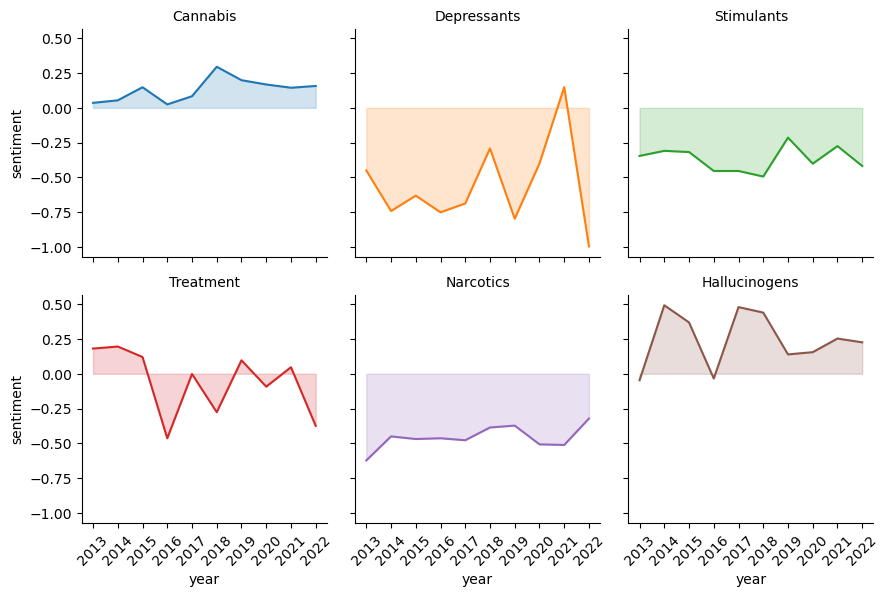

<Figure size 500x1000 with 0 Axes>

In [51]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


frames = [cannabis_sent_classes, depress_sent_classes, stimulants_sent_classes, treatment_sent_classes, narcotics_sent_classes, hallucinogens_sent_classes]
  
df = pd.concat(frames)
df['drug_class'] = df['drug_class'].str.capitalize()

# Create a grid : initialize it
g = sns.FacetGrid(df, col='drug_class', hue='drug_class', col_wrap=3, legend_out=True)

# Add the line over the area with the plot function
g = g.map(plt.plot, 'year', 'sentiment')
 
# Fill the area with fill_between
y = [0,0,0,0,0,0,0,0,0,0]
g = g.map(plt.fill_between, 'year', 'sentiment', alpha=0.2).set_titles("{col_name} drug_class")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plot
plt.subplots_adjust(top=0.92)
for ax in g.fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)

# Show the graph
plt.figure(figsize=(5,10))

plt.show()

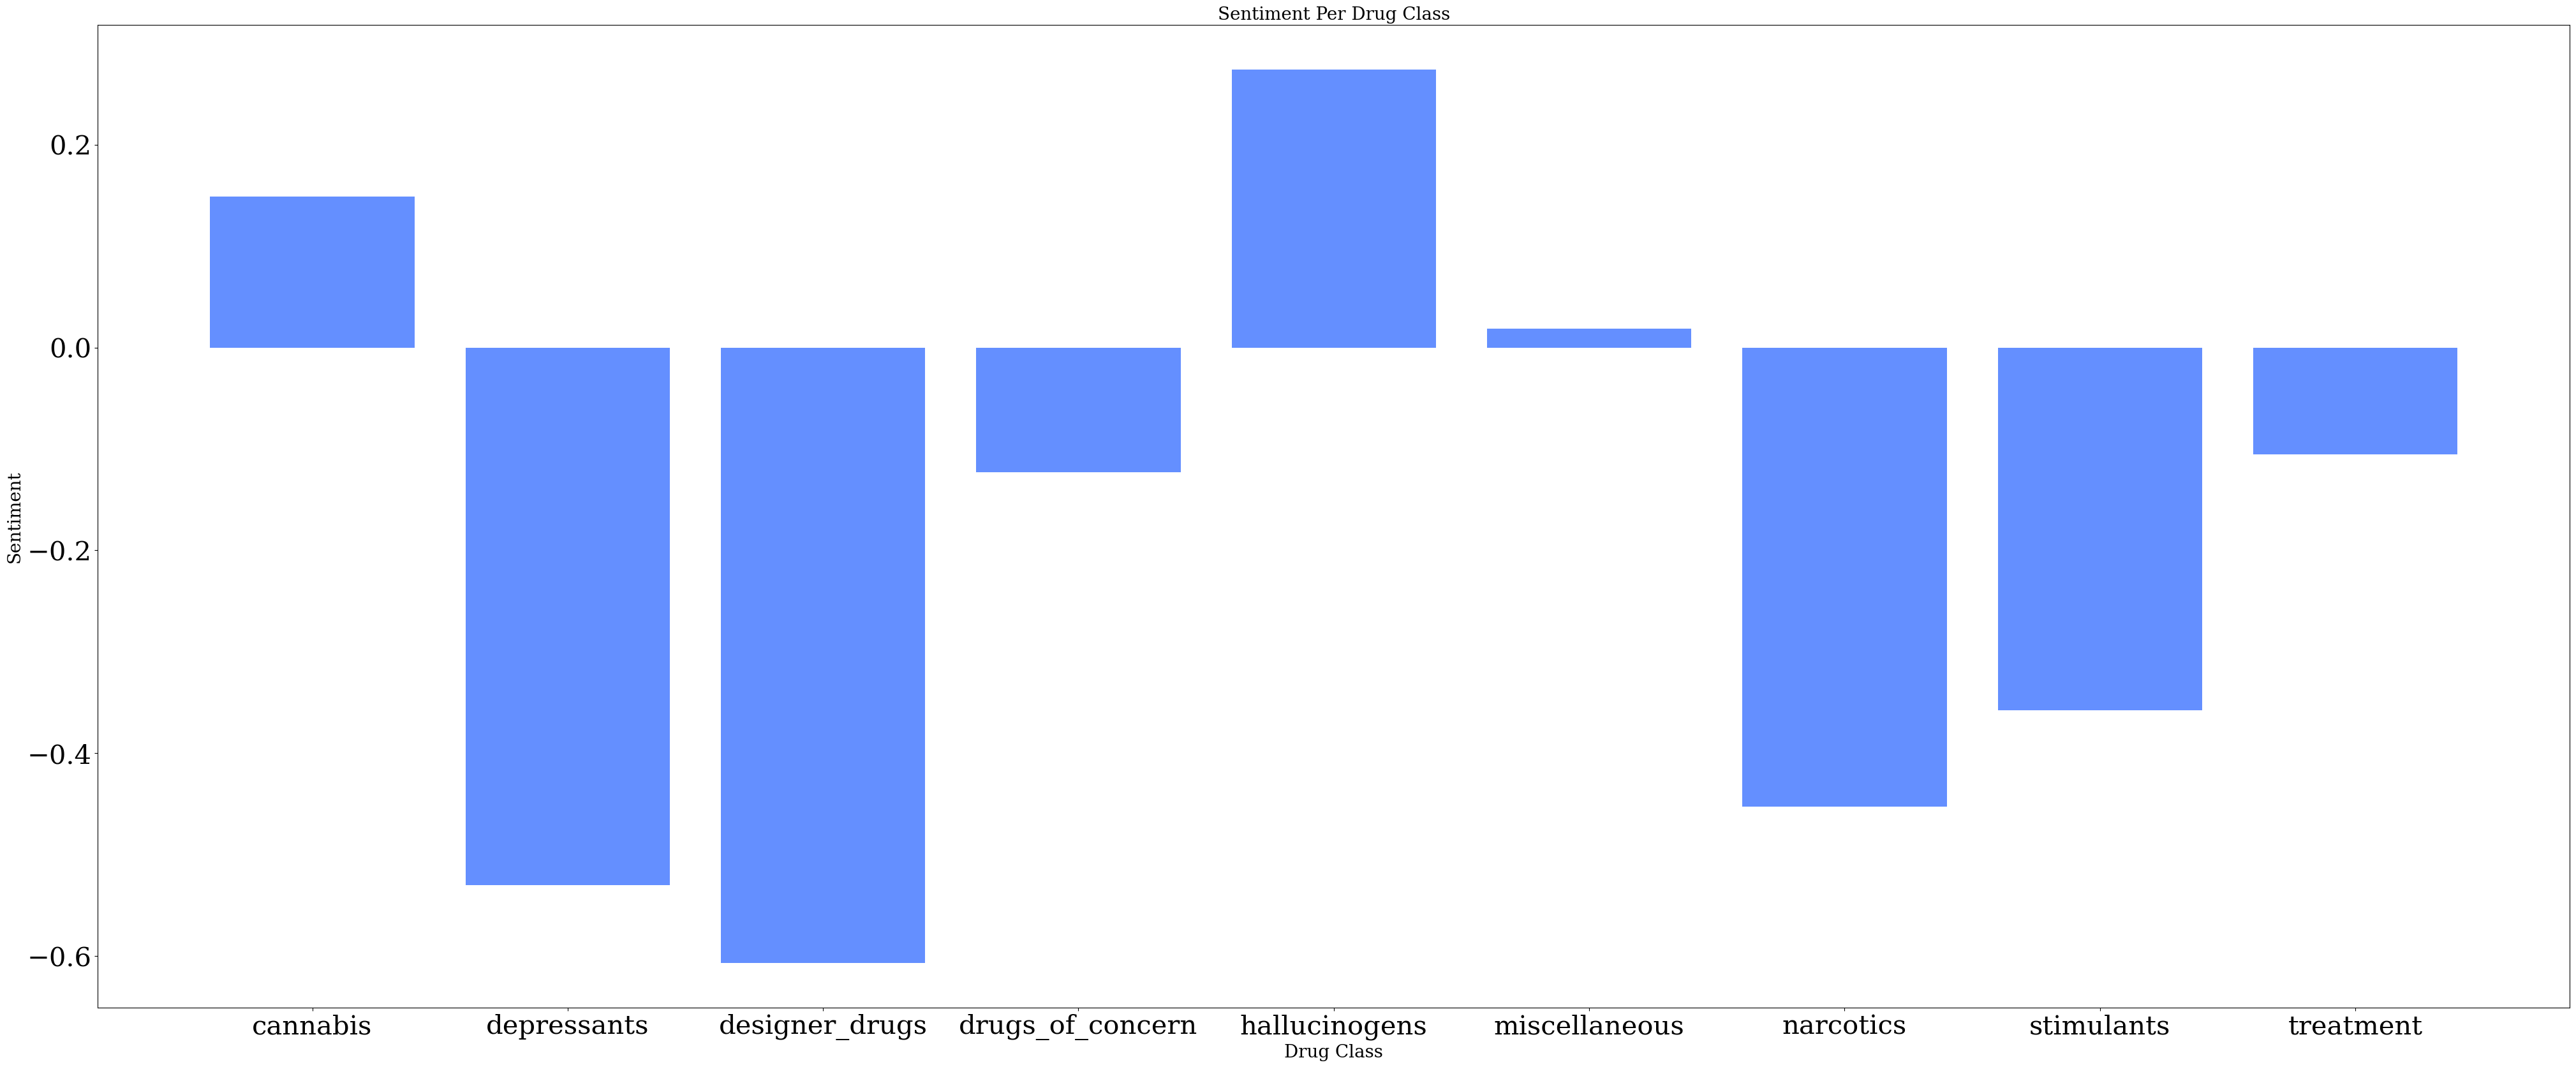

In [85]:
# average sentiment per class
# drug_articles["sentiment"] = drug_articles["sentiment"].apply(lambda x: 0 if x == 0 else 1 if x > 0 else -1)
sent_class = drug_articles[["drug_class", "sentiment"]].explode("drug_class").reset_index(drop=True)
sent_class.groupby("drug_class")["sentiment"].mean().sort_values(ascending=False)

# plot
fig, ax = plt.subplots(figsize=(50, 20))
ax.bar(sent_class.groupby("drug_class")["sentiment"].mean().index, sent_class.groupby("drug_class")["sentiment"].mean().values, label="Sentiment", color = "#648FFF")
# set x axis to be every 6 months
# ax.set_xlim(sentiment_scores["Date"].iloc[0], sentiment_scores["Date"].iloc[-1])

ax.set_xlabel("Drug Class", fontsize=20)
ax.set_ylabel("Sentiment", fontsize=20)
ax.set_title("Sentiment Per Drug Class", fontsize=20)

plt.show()


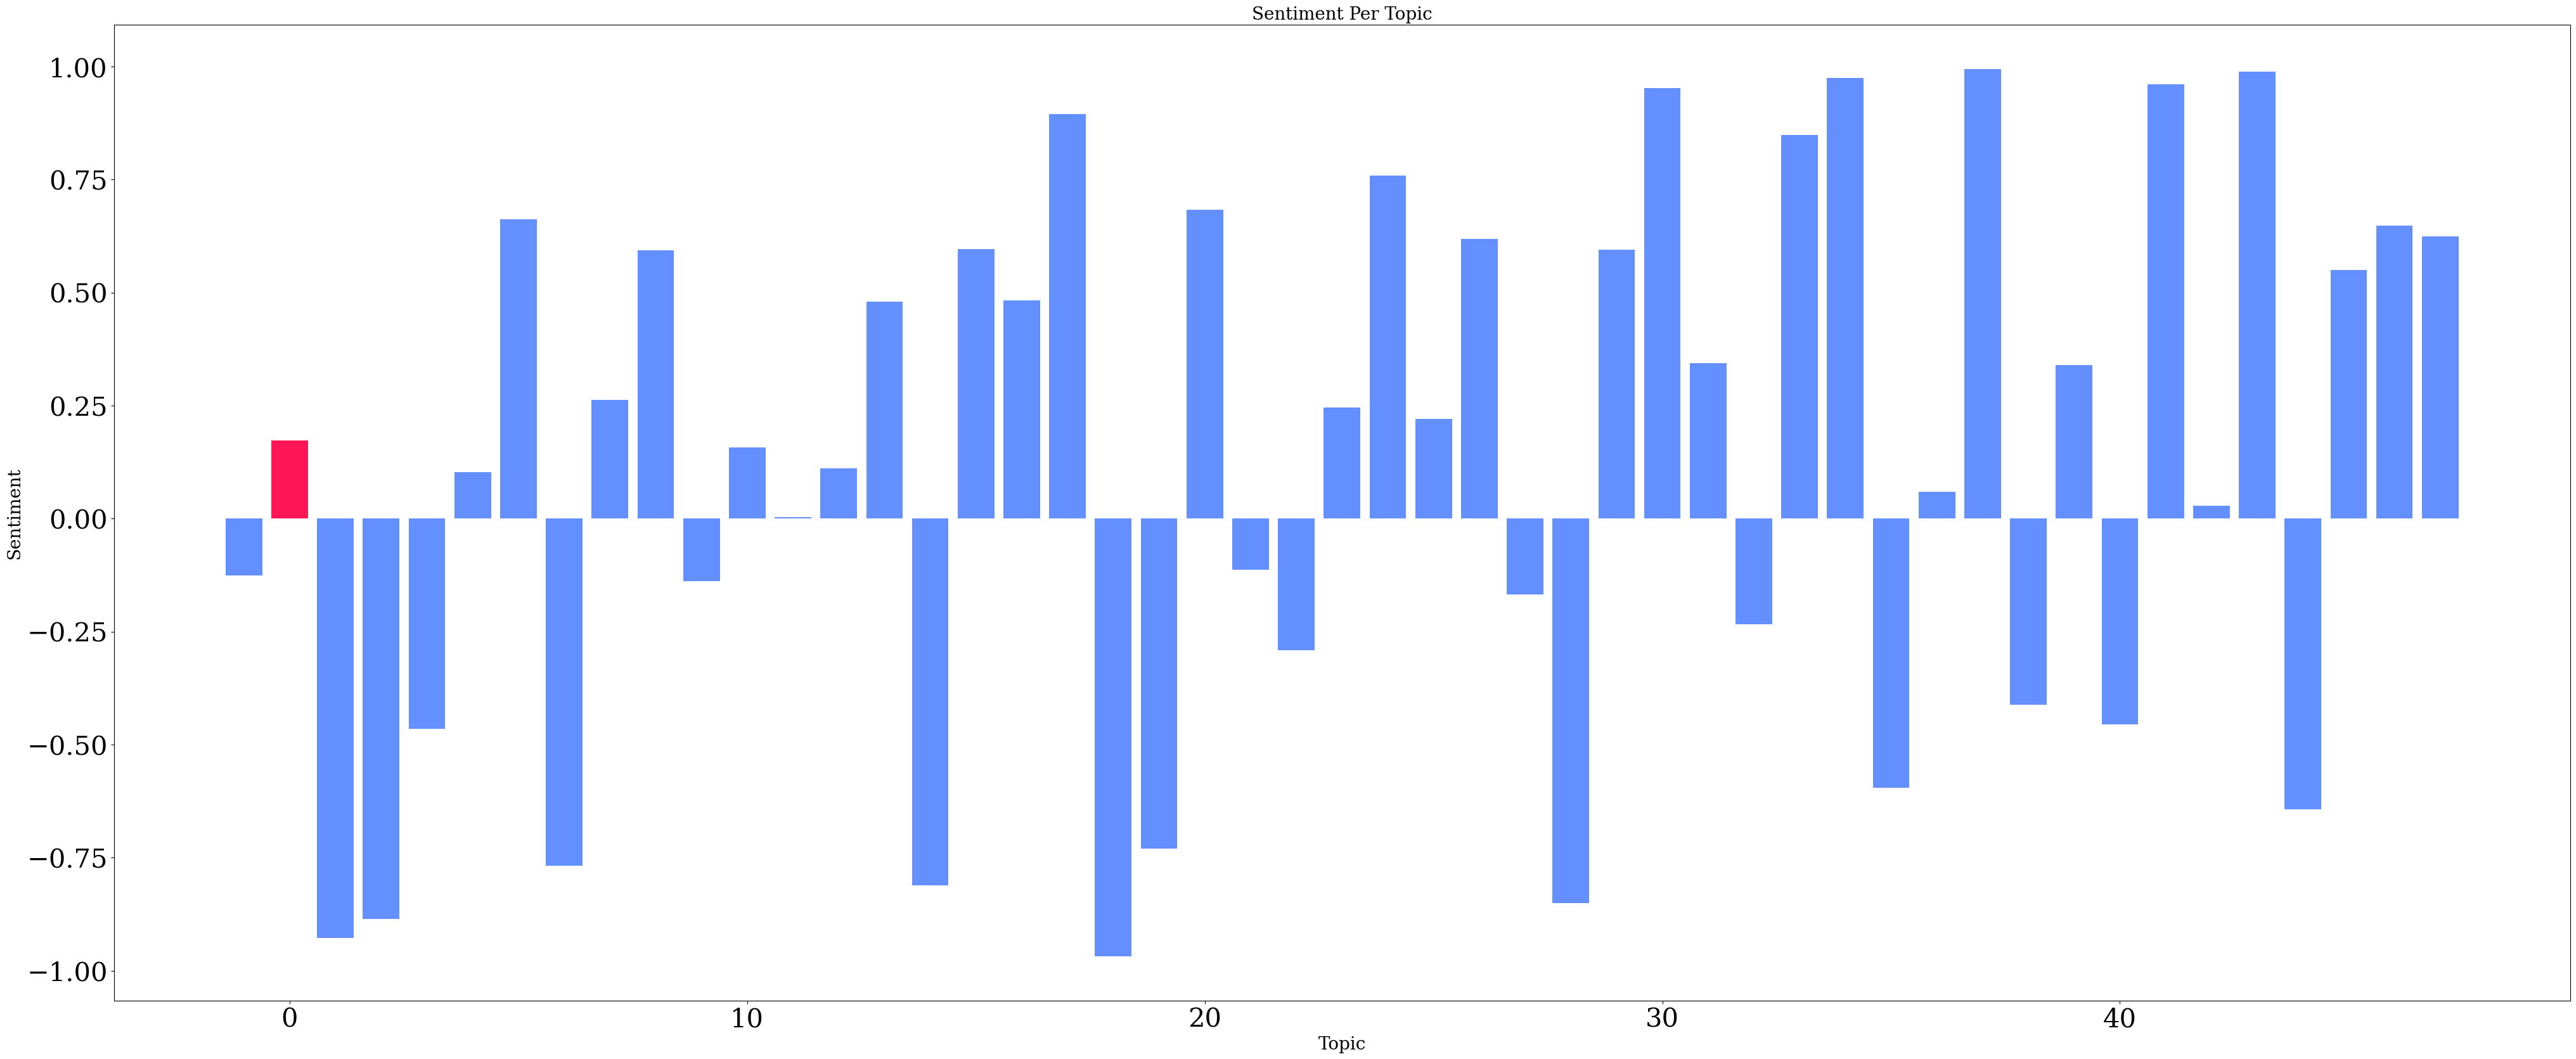

In [87]:
# average sentiment per topic
# add topic to drug_articles
drug_articles["topic"] = topics

sent_topic = drug_articles.groupby("topic")["sentiment"].mean()

# visualize
fig, ax = plt.subplots(figsize=(50, 20))
ax.bar(sent_topic.index, sent_topic.values, label="Sentiment", color = "#648FFF")

ax.set_xlabel("Topic", fontsize=20)
ax.set_ylabel("Sentiment", fontsize=20)
ax.set_title("Sentiment Per Topic", fontsize=20)

# make topic 0 a different color
ax.bar(0, sent_topic[0], label="Sentiment", color = "#FF1654")

plt.show()

In [115]:
# export notebook to html
!jupyter nbconvert --to html get-drug-articles.ipynb --output bertopic



[NbConvertApp] Converting notebook get-drug-articles.ipynb to html
/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/nbconvert/filters/widgetsdatatypefilter.py:69: UserWarning: Your element with mimetype(s) dict_keys(['application/vnd.plotly.v1+json']) is not able to be represented.
  warn("Your element with mimetype(s) {mimetypes}"
[NbConvertApp] Writing 5047582 bytes to bertopic.html


---

In [515]:
# train word embedding

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# train word embedding
model = Word2Vec(drug_articles["clean_text"], window=5, min_count=1, workers=4)
model.save("word2vec_drug.model")



In [517]:
model_all = Word2Vec(articles_df["clean_text"], window=5, min_count=1, workers=4)
model_all.save("word2vec_all.model")

In [518]:
# get similaroty
model.wv.most_similar("drug")


[('heroin', 0.811974287033081),
 ('drugs', 0.8040395975112915),
 ('opioid', 0.7787541151046753),
 ('crime;', 0.7786349058151245),
 ('(law', 0.770026445388794),
 ('drugs.', 0.7463937997817993),
 ('street-level', 0.7396299242973328),
 ('substance', 0.7381671071052551),
 ('gray-area', 0.7379523515701294),
 ('strategies”', 0.7371699213981628)]

In [519]:
model_all.wv.most_similar("drug")

[('drugs', 0.8181858658790588),
 ('drugs,', 0.7662932276725769),
 ('drugs.', 0.7574038505554199),
 ('heroin', 0.7501494288444519),
 ('opioid', 0.7386726140975952),
 ('painkiller', 0.7373161315917969),
 ('painkillers.', 0.7349890470504761),
 ('opioids', 0.7348196506500244),
 ('prescription', 0.7305832505226135),
 ('cocaine', 0.7234899401664734)]

In [520]:
model.wv.most_similar("addiction")

[('crisis,', 0.9229638576507568),
 ('addiction,', 0.9211131930351257),
 ('treatment.', 0.9156417846679688),
 ('detox', 0.9147344827651978),
 ('inpatient', 0.9113808870315552),
 ('treatment,', 0.9102936387062073),
 ('treatment', 0.909673810005188),
 ('methadone', 0.9086586833000183),
 ('naloxone', 0.9079819917678833),
 ('lifesaving', 0.9058586359024048)]

In [521]:
model_all.wv.most_similar("addiction")

[('addiction,', 0.8883450031280518),
 ('addiction.', 0.793436586856842),
 ('addictions', 0.7801242470741272),
 ('opioid', 0.7587930560112),
 ('addicts', 0.7524212598800659),
 ('homelessness', 0.7430515289306641),
 ('addicts,', 0.7405060529708862),
 ('alcoholism', 0.7358806133270264),
 ('homelessness,', 0.730496883392334),
 ('opiate', 0.7263909578323364)]

In [523]:
model.wv.most_similar("treatment")

[('inpatient', 0.9507994651794434),
 ('outpatient', 0.9373016357421875),
 ('programs', 0.9278790354728699),
 ('treatment,', 0.9261306524276733),
 ('treatment.', 0.9192273616790771),
 ('addiction', 0.9096737504005432),
 ('drug-treatment', 0.9033596515655518),
 ('counseling', 0.9026219844818115),
 ('providers', 0.9011002779006958),
 ('locating', 0.894824743270874)]

In [524]:
model_all.wv.most_similar("treatment")

[('treatment,', 0.8412596583366394),
 ('treatments', 0.7758861780166626),
 ('medication', 0.7711909413337708),
 ('methadone', 0.765705406665802),
 ('treatment.', 0.7539603114128113),
 ('buprenorphine', 0.7452856302261353),
 ('medically', 0.7284226417541504),
 ('psychiatric', 0.7260622978210449),
 ('medications', 0.7228405475616455),
 ('addiction', 0.7174538373947144)]